### AutoGen实战 
本节课，我们深入探索autogen的各种能力，包括：

一、检索增强的聊天

&emsp;&emsp;1.1 使用RetrieveChat进行检索增强代码生成和问答

&emsp;&emsp;1.2 RetrieveChat实例

&emsp;&emsp;&emsp;&emsp;应用1：无需人类反馈的检索聊天：基于文档生成代码

&emsp;&emsp;&emsp;&emsp;应用2：无需人类反馈的检索聊天：基于文档回答问题

&emsp;&emsp;&emsp;&emsp;应用3：含人类反馈的检索聊天：基于文档生成代码

&emsp;&emsp;&emsp;&emsp;应用4：含人类反馈的检索聊天：基于文档回答问题

&emsp;&emsp;&emsp;&emsp;应用5：含人类反馈的检索聊天：基于文档回答问题

&emsp;&emsp;1.3 定制RetrieveUserProxyAgent 

&emsp;&emsp;&emsp;&emsp;1.3.1 定制嵌入函数 

&emsp;&emsp;&emsp;&emsp;1.3.2 定制文本分割函数 

&emsp;&emsp;&emsp;&emsp;1.3.3 定制向量数据库  

&emsp;&emsp;&emsp;&emsp;1.4 RetrieveChat实战：自动群聊

二、教会大模型新的技能：TeachableAgent

&emsp;&emsp;应用1：学习用户信息

&emsp;&emsp;应用2：学习新的事实

&emsp;&emsp;应用3：学习用户偏好

&emsp;&emsp;应用4：学习新的技能

三、自动构建的多智能体系统

四、使用代码解释器的GPTAssistant

&emsp;&emsp;应用1：数学问题求解

&emsp;&emsp;应用2：使用代码解释器绘图

五、再探群聊

&emsp;&emsp;5.1 使用select_speaker实现多层次的信息流

&emsp;&emsp;5.2 使用图结构建模聊天路径


&emsp;&emsp;本节课我们介绍AutoGen在实际使用中比较有用的功能：利用RAG技术来增强LLM使用外部知识的能力，从而拓宽LLM的能力范围。介绍TeachableAgent，来持久化LLM学习到的知识，这样能减少一些重复的输入提示词的工作。随后介绍AutoGen的自动构建，在我们还没想好如何构建Agent时可以提供一些灵感。然后介绍如何与GPT4的重要功能代码解释器进行交互。最后，我们再来学习如何定制群聊中的发言逻辑，让自动群聊更加符合预期。



# 材料准备
<div class="alert alert-warning">
    <b>
        注意:
    </b>4.5的代码使用与4.4相同的环境运行，有需要额外的安装会在课件中提到。
</div>

在开始之前我们先提前准备好一些文件：


In [2]:
!mkdir docs
!mkdir sentence-transformers_all-mpnet-base-v2
!curl -o docs/Research.md https://raw.githubusercontent.com/microsoft/FLAML/main/website/docs/Research.md
!curl -o docs/Spark.md https://raw.githubusercontent.com/microsoft/FLAML/main/website/docs/Examples/Integrate%20-%20Spark.md

mkdir: cannot create directory ‘docs’: File exists
mkdir: cannot create directory ‘sentence-transformers_all-mpnet-base-v2’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4588  100  4588    0     0   2811      0  0:00:01  0:00:01 --:--:--  2809
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6625  100  6625    0     0   3057      0  0:00:02  0:00:02 --:--:--  3057


下载[sentence-transformers](https://huggingface.co/sentence-transformers/all-mpnet-base-v2/tree/main)模型，将这个页面上所有文件下载下来，放入src/sentence-transformers_all-mpnet-base-v2文件夹。

下载[xtreme数据](https://huggingface.co/datasets/google/xtreme/tree/main/MLQA.zh.zh)，把其中的validation-00000-of-00001.parquet保存在docs文件夹中，运行处理脚本：



In [1]:
!pip install pyarrow

Looking in indexes: http://mirrors.tencentyun.com/pypi/simple


In [2]:
import json
import pyarrow.parquet as pq

# 读取Parquet文件
table = pq.read_table('./docs/validation-00000-of-00001.parquet')

df = table.to_pandas()
data = df.to_json(orient='records', lines=False)

data = json.loads(data)

result = []
for row in data:
    if row['context'] not in result:
        result.append(row['context'])


with open('./docs/xtreme_context.json','w', encoding='utf-8') as out:
    json.dump(result[:87], out,ensure_ascii=False,indent=4)

## 一、检索增强的聊天
本章节内容：
- RAG技术介绍
- 使用RetrieveChat进行检索增强代码生成和问答
- RetrieveChat实例
- 定制RetrieveUserProxyAgent 
- RetrieveChat实战：自动群聊

<div class="alert alert-warning">
### AutoGen版本提醒
本章节使用的AutoGen版本为pyautogen==0.6.1，
</div>

&emsp;&emsp;**RAG（Retrieval Augmented Generation,检索增强生成）是一种使用从外部来源获取的事实，来提高生成式 AI 模型准确性和可靠性的技术**。

**LLM的知识更新难题**

&emsp;&emsp;在进入RAG的介绍之前，需要首先理解一个概念，LLM的知识更新是很困难的，主要原因在于：
- LLM的训练数据集是固定的,一旦训练完成就很难再通过继续训练来更新其知识。
- LLM的参数量巨大,随时进行fine-tuning需要消耗大量的资源，并且需要相当长的时间
- LLM的知识是编码在数百亿个参数中的,无法直接查询或编辑其中的知识图谱。

&emsp;&emsp;因此,LLM的知识具有静态、封闭和有限的特点。为了赋予LLM持续学习和获取新知识的能力,RAG应运而生。

**工作原理**

&emsp;&emsp;RAG本质上是通过工程化手段，解决LLM知识更新困难的问题。其核心手段是利用外挂于LLM的知识数据库（通常使用向量数据库）存储未在训练数据集中出现的新数据、领域数据等。通常而言，RAG将知识问答分成三个阶段：索引、知识检索和基于内容的问答。

- 第一阶段是**知识索引**，需要事先将文本数据进行处理,通过词嵌入（Embedding）等向量化技术，将文本映射到低维向量空间，并将向量存储到数据库中，构建起可检索的向量索引。在这个阶段，RAG涉及数据加载器、分割器、向量数据库、提示工程等组件以及LLM本身。
&emsp;&emsp;Embedding是一种表示方法，即把原始输入数据分布地表示成一系列特征的线性组合。比如最典型的例子，我们知道颜色可以使用RGB表示法，这就是一种Embedding表示：

| 颜色   | 局部表示          | 分布式表示              |
| ------ | ---------------- | ----------------------- |
| 琥珀色 | \([1, 0, 0, 0]^T\) | \([1.00, 0.75, 0.00]^T\) |
| 天蓝色 | \([0, 1, 0, 0]^T\) | \([0.00, 0.5, 1.00]^T\)  |
| 中国红 | \([0, 0, 1, 0]^T\) | \([0.67, 0.22, 0.12]^T\) |
| 咖啡色 | \([0, 0, 0, 1]^T\) | \([0.44, 0.31, 0.22]^T\) |

&emsp;&emsp;而具体到NLP中，每一个词都被表示成指定维度（比如300或者768）的向量，每一个维度对应词的一种语义特征。跟颜色的Embedding不同的是，我们知道RGB表示法中三个特征的物理意义，但是在NLP中，我们显然不可能从语言学角度先验地知道每一个维度具体表示哪一种语义特征，也没法知道一个词语对应的特征值具体是多少，所以这就需要通过语言模型训练来得到每个词嵌入（word embedding）。

&emsp;&emsp;得到word embedding之后，可以通过累加、平均、加权等简单的方式得到句子嵌入（sentence embedding），在BERT模型问世后，常见的方式是将CLS向量对应的输出向量作为sentence embedding。

- 第二阶段是**知识检索**，当输入一个问题时，RAG会对知识库进行检索，找到与问题最相关的一批文档。这需要依赖于第一阶段建立的向量索引，根据向量间的相似性进行快速检索。
  
- 第三阶段是**生成答案**，RAG会把输入问题及相应的检索结果文档一起提供给LLM，让LLM充分把这些外部知识融入上下文，并生成相应的答案。RAG控制生成长度,避免生成无关内容。

&emsp;&emsp;这样,LLM就能够充分利用外部知识库的信息,而不需要修改自身的参数。当知识库更新时,新知识也可以通过prompt实时注入到LLM中。这种设计既发挥了LLM强大的语言生成能力,又规避了其知识更新的困境,使之能更智能地回答各类问题,尤其是需要外部知识支持的问题。

&emsp;&emsp;为了理解这一技术，让我们以法庭为例。法官通常根据对法律的一般理解来审理和判决案件。但有些案件需要用到特殊的专业知识，如医疗事故诉讼或劳资纠纷等，因此法官会派法庭书记员去图书馆寻找可以引用的先例和具体案例。与优秀的法官一样，大语言模型（LLM）能够响应人类的各种查询。但为了能够提供引经据典的权威答案，模型需要一个助手来做一些研究。AI 的“法庭书记员”就是一个被称为检索增强生成（RAG）的过程。 

**优点**

RAG的优点主要体现在以下几个方面：

- 可以利用大规模外部知识改进LLM的推理能力和事实性。
- 使用LangChain等框架可以快速实现原型。
- 第一阶段的知识索引可以随时新增数据，延迟非常低，可以忽略不计。因此RAG架构理论上能做到知识的实时更新。
- 可解释性强，RAG可以通过提示工程等技术，使得LLM生成的答案具有更强的可解释性，从而提高了用户对于答案的信任度和满意度。

**缺点**

RAG也有不少缺点：

- 知识检索阶段依赖相似度检索技术，并不是精确检索，因此有可能出现检索到的文档与问题不太相关。
- 在第三阶段生产答案时，由于LLM基于检索出来的知识进行总结，可能缺乏一些基本世界知识，从而导致无法应对用户询问知识库之外的基本问题。
- 向量数据库是一个尚未成熟的技术，缺乏处理大量数据规模的通用方案，因此数据量较大时,速度和性能存在挑战。
- 在推理时需要对用户输入进行预处理和向量化等操作，增加了推理的时间和计算成本。
- 外部知识库的更新和同步，需要投入人力、物力和时间。
- 需要额外的检索组件，增加了架构的复杂度和维护成本。

### 1.1使用RetrieveChat进行检索增强代码生成和问答

&emsp;&emsp;RetrieveChat是AutoGen用于检索增强生成和问答的对话系统。**在这一系列应用中，我们展示如何利用RetrieveChat根据FLAML文档来生成代码和回答问题**。RetrieveChat使用RetrieveAssistantAgent(检索增强助手)和RetrieveUserProxyAgent(检索增强用户代理)，类似于前面AssistantAgent和UserProxyAgent的用法（例如，带有代码生成、执行和调试的自动任务解决）。实质上，RetrieveAssistantAgent和RetrieveUserProxyAgent实现了针对RetrieveChat提示的不同自动回复机制。

> [FLAML](https://github.com/microsoft/FLAML)是一个轻量级的Python库，用于高效自动化机器学习和人工智能操作。它可以根据大型语言模型、机器学习模型等自动化工作流程，并优化其性能。

&emsp;&emsp;要使用检索增强聊天，需要初始化两个代理，包括检索增强用户代理和检索增强助手。初始化检索增强用户代理需要指定文档集合的路径。随后，**检索增强用户代理可以下载文档，将其分成特定大小的块，计算词嵌入并将它们存储在向量数据库中**。

&emsp;&emsp;一旦启动了聊天，代理将根据以下流程协同进行代码生成或问答：

<div align="center">
 <img src="images/7f5b958dbdd0c6e4f5a70fe1852a9a2ad86e44ad56e2d5bc7a02105679c8b6d0.png" alt="扁平结构"/>
</div>

1. 检索增强用户代理**基于嵌入相似性检索文档块**，并将它们与问题一起发送到检索增强助手。
2. 检索增强助手利用LLM根据提供的问题和上下文生成代码或文本作为答案。如果LLM无法生成满意的响应，它会被指示回复“更新上下文”给检索增强用户代理。
3. 如果响应包含代码块，检索增强用户代理执行代码并将输出作为反馈发送。如果没有代码块或更新上下文的指令，则终止对话。否则，它会更新上下文并将问题与新上下文转发给检索增强助手。请注意，如果启用了人类输入请求，个人可以主动发送任何反馈，包括“更新上下文”给检索增强助手。
4. **如果检索增强助手收到“更新上下文”，它会从检索增强用户代理请求下一个最相似的文档块作为新的上下文**。否则，它会根据反馈和聊天历史生成新的代码或文本。如果LLM无法生成答案，它再次回复“更新上下文”。这个过程可以重复多次。如果没有更多文档可用于上下文，对话将终止。


<div class="alert alert-info">
Retrievechat官方文档：https://microsoft.github.io/autogen/0.2/docs/notebooks/agentchat_RetrieveChat
</div>

&emsp;&emsp;检索的文档储存在向量数据库中，以支持高效的存储和检索功能。可以存储在向量数据库实例中的接受的文件格式包括：

In [1]:
from autogen.retrieve_utils import TEXT_FORMATS

print("`docs_path` 可接受的文档类型:")
print(TEXT_FORMATS)

/Users/zhuwentao/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


`docs_path` 可接受的文档类型:
['txt', 'json', 'csv', 'tsv', 'md', 'html', 'htm', 'rtf', 'rst', 'jsonl', 'log', 'xml', 'yaml', 'yml', 'pdf', 'mdx']


/Users/zhuwentao/anaconda3/lib/python3.11/site-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


我们首先初始化RetrieveAssistantAgent和RetrieveUserProxyAgent。system_message设置为“您是一个有用的助手”，用于RetrieveAssistantAgent。详细的请求则在用户消息中给出。generate_init_prompt将说明和检索增强生成任务组合成一个初始提示，以发送给LLM助手。

In [1]:
from autogen.agentchat.contrib.retrieve_assistant_agent import RetrieveAssistantAgent
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent
from autogen import AssistantAgent, UserProxyAgent, config_list_from_json
import chromadb #向量数据库
import os

# 配置魔法地址，对于访问openai的模型是必要的
# import os
# os.environ["http_proxy"]="127.0.0.1:7890"
# os.environ["https_proxy"]="127.0.0.1:7890"

# 加载LLM配置
config_list = config_list_from_json(env_or_file="OAI_CONFIG_LIST.json")
config_list = config_list_from_json(env_or_file="ds.json")

/Users/zhuwentao/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/zhuwentao/anaconda3/lib/python3.11/site-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


In [2]:
config_list

[{'model': 'deepseek-chat',
  'api_key': 'sk-563b49bcebaa4e2895340379c21e6e8a',
  'base_url': 'https://api.deepseek.com'}]

In [3]:
# 创建一个名为"assistant"的RetrieveAssistantAgent实例
assistant = RetrieveAssistantAgent(
    name="assistant",
    system_message="您是一个有用的助手。",
    llm_config={
        "timeout": 600,
        "cache_seed": 42,
        "config_list": config_list
    }
)

/var/folders/4p/55xkvt9d4kbgyyz8y_5rj_yh0000gn/T/ipykernel_88209/4054786148.py:2: DeprecationWarning: The RetrieveAssistantAgent is deprecated. Please use the AssistantAgent instead.
  assistant = RetrieveAssistantAgent(


In [4]:

from chromadb.utils import embedding_functions

sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name="src/sentence-transformers_all-mpnet-base-v2"
)

In [ ]:
# chromadb数据库初始化
# client = chromadb.PersistentClient(path="./tmp/chromadb") 

# 创建一个名为"ragproxyagent"的RetrieveUserProxyAgent实例
ragproxyagent = RetrieveUserProxyAgent(
    name="ragproxyagent",
    human_input_mode="ALWAYS",
    max_consecutive_auto_reply=3,
    # 文档检索配置
    retrieve_config={
        "task": "code",
        "docs_path": [
            "./docs/Research.md", # FLAML文档的引用
            "./docs/Spark.md" # FLAML文档关于如何与spark交互的部分
        ],
        "custom_text_types": ["mdx"],
        "chunk_token_size": 2000,
        "model": config_list[0]["model"],
        "embedding_function": sentence_transformer_ef,  # 使用自定义的embedding_function
        # "embedding_model": "src/sentence-transformers_all-mpnet-base-v2",
        "overwrite": True,  
        "vector_db": "chroma"
    },
    code_execution_config=False,# 这个例子中我们不执行代码
)

创建名为“ragproxyagent”的RetrieveUserProxyAgent实例。
**retrieve_config**为文档检索的配置：
- **task**：检索聊天的任务。可能的值包括 "code"、"qa" 和 "default"。不同任务将有不同的系统提示语。默认值是 default，支持代码和问答。
- **client**：chromadb 客户端。如果未提供该键，则将使用默认客户端 chromadb.Client()。如果您想使用其他向量数据库，请扩展此类并覆盖 retrieve_docs 函数。
- **docs_path**是文档目录的路径。它也可以是单个文件的路径或单个文件的URL。默认情况下，它设置为None。
- **collection_name**：数据库collection的名称。在向量数据库中，collection是一组具有相似属性的文档集合，相当于关系型数据库中的表。如果未提供该键，则将使用默认名称 “autogen-docs”
- **model**：用于检索聊天的模型。如果未提供该键，则将使用默认模型 gpt-4
- **task**指示我们正在处理的任务类型。在这个例子中，它是一个“code”任务。
- **chunk_token_size**是用于检索聊天的块token大小。默认情况下，它设置为max_tokens * 0.6，在这里我们将其设置为2000。
- **embedding_model**：用于检索聊天的嵌入模型。如果未提供该键，则将使用默认模型 all-MiniLM-L6-v2。所有可用模型都可以在 https://www.sbert.net/docs/pretrained_models.html 找到。默认模型是一个快速模型。如果您想使用高性能模型，推荐使用 all-mpnet-base-v2。
- **embedding_function**：用于创建向量数据库的嵌入函数。默认为 None，将使用具有给定 embedding_model 的 SentenceTransformer。如果您想使用 OpenAI、Cohere、HuggingFace 或其他嵌入函数，可以在此处传递，遵循 https://docs.trychroma.com/embeddings 中的示例。
- **customized_prompt**：检索聊天的定制提示语。默认为 None。
- **customized_answer_prefix**：检索聊天的定制答案前缀。默认为 ""。如果不为 ""，且答案中没有该定制答案前缀，将触发 Update Context
- **update_context**：如果为 False，将不会触发 Update Context。默认为 True。
- **custom_text_types**是要处理的文件类型列表。默认是前面运行过的autogen.retrieve_utils.TEXT_FORMATS。这仅适用于docs_path目录下的文件。明确包含的文件和URL将被分块，而不管它们的类型如何。在这个例子中，我们将其设置为["mdx"]，以便仅处理Markdown文件。如果在websit/docs中没有包含任何mdx文件，则不会处理任何文件。

通过RetrieveUserProxyAgent发送给assistant的默认提示语，我们也可以进一步理解检索聊天的流程：

> PROMPT_DEFAULT = """ 你是一个增强型检索聊天机器人。你基于自己的知识和用户提供的上下文来回答用户的问题。你应该按照以下步骤来回答问题：
步骤1，根据问题和上下文估计用户的意图。意图可以是代码生成任务或问题回答任务。
步骤2，根据意图进行回复。
如果你无法用当前的上下文回答问题，你应该准确回复 UPDATE CONTEXT。
如果用户的意图是代码生成，你必须遵守以下规则：
规则1：你不能安装任何包，因为所有所需的包都已经安装好了。
规则2：你必须按照以下格式编写你的代码：
\```language
\# your code
\```
如果用户的意图是问题回答，你必须给出尽可能简短的答案。
用户的问题是：{input_question}
上下文是：{input_context}
"""

### 1.2 RetrieveChat实例
#### 应用1：无需人类反馈的检索聊天：基于文档生成代码

&emsp;&emsp;让chatgpt使用最新的框架来写代码不行，因为它的训练语料具有时效性，但是借助检索增强，我们便可以让chatgpt参考文档来写代码。

&emsp;&emsp;问题：如果我想在分类任务中使用FLAML，并希望在30秒内训练模型，我应该使用哪个API？使用Spark并行训练。如果达到时间限制，请强制取消作业。

> [Apache Spark](https://github.com/apache/spark)是用于大规模数据（large-scala data）处理的统一（unified）分析引擎。

In [1]:
# 每次开启一个新对话时都重置agent
assistant.reset()
ragproxyagent.reset()

# 在给定问题的情况下，我们使用ragproxyagent生成一个prompt，作为初始消息发送给助手。
# 助手接收消息并生成回应。回应将被发送回ragproxyagent进行处理。
# 对话会持续进行，直到满足终止条件，在RetrieveChat中，当没有检测到代码块时为终止条件。
# 有人参与时，对话将一直持续，直到用户说“exit”。
code_problem = "如果我想在分类任务中使用FLAML，并希望在30秒内训练模型，我应该使用哪个API？使用Spark并行训练。如果达到时间限制，请强制取消作业。"

# search_string是作为embeddings搜索的额外过滤条件, 在这个例子中，我们只想搜索那些包含"spark"的文档。
ragproxyagent.initiate_chat(assistant, message=ragproxyagent.message_generator, problem=code_problem, search_string="spark")  


NameError: name 'assistant' is not defined

#### 应用2：无需人类反馈的检索聊天：基于文档回答问题

借助检索增强，我们可以让chatgpt拥有最新的知识，这时再进行提问得到的回复相对会更加正确。

In [10]:
# 重置assistant
assistant.reset()

# 提问
qa_problem = "谁是FLAML的作者?"
ragproxyagent.initiate_chat(assistant, message=ragproxyagent.message_generator,problem=qa_problem)

Number of requested results 20 is greater than number of elements in index 2, updating n_results = 2
Model deepseek-chat not found. Using cl100k_base encoding.


VectorDB returns doc_ids:  [['bdfbc921', '7968cf3c']]
Adding content of doc bdfbc921 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 7968cf3c to context.
ragproxyagent (to assistant):

You're a retrieve augmented coding assistant. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
For code generation, you must obey the following rules:
Rule 1. You MUST NOT install any packages because all the packages needed are already installed.
Rule 2. You must follow the formats below to write your code:
```language
# your code
```

User's question is: 谁是FLAML的作者?

Context is: # Integrate - Spark

FLAML has integrated Spark for distributed training. There are two main aspects of integration with Spark:

- Use Spark ML estimators for AutoML.
- Use Spark to run training in parallel spark jobs.

## Spark ML Estimators

FLAML integrates estimators based on Spark ML models. These models are trained in parallel using Spark, so we called them Spark estimators. 

ChatResult(chat_id=None, chat_history=[{'content': 'You\'re a retrieve augmented coding assistant. You answer user\'s questions based on your own knowledge and the\ncontext provided by the user.\nIf you can\'t answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.\nFor code generation, you must obey the following rules:\nRule 1. You MUST NOT install any packages because all the packages needed are already installed.\nRule 2. You must follow the formats below to write your code:\n```language\n# your code\n```\n\nUser\'s question is: 谁是FLAML的作者?\n\nContext is: # Integrate - Spark\n\nFLAML has integrated Spark for distributed training. There are two main aspects of integration with Spark:\n\n- Use Spark ML estimators for AutoML.\n- Use Spark to run training in parallel spark jobs.\n\n## Spark ML Estimators\n\nFLAML integrates estimators based on Spark ML models. These models are trained in parallel using Spark, so we called them Spark estimator

#### 应用3：含人类反馈的检索聊天：基于文档生成代码

这里演示chatgpt生成代码的同时加入我们的反馈，让代码更符合要求。

In [11]:
# 重置assistant
assistant.reset()

# 将`human_input_mode`设置为`ALWAYS`, 让agent在每一步都寻求反馈
ragproxyagent.human_input_mode = "ALWAYS"

# 提问
code_problem = "如何使用FLAML构建一个股票价格的时间序列预测模型？"
ragproxyagent.initiate_chat(assistant, message=ragproxyagent.message_generator,problem=code_problem)

Number of requested results 20 is greater than number of elements in index 2, updating n_results = 2
Model deepseek-chat not found. Using cl100k_base encoding.


VectorDB returns doc_ids:  [['bdfbc921', '7968cf3c']]
Adding content of doc bdfbc921 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 7968cf3c to context.
ragproxyagent (to assistant):

You're a retrieve augmented coding assistant. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
For code generation, you must obey the following rules:
Rule 1. You MUST NOT install any packages because all the packages needed are already installed.
Rule 2. You must follow the formats below to write your code:
```language
# your code
```

User's question is: 如何使用FLAML构建一个股票价格的时间序列预测模型？

Context is: # Integrate - Spark

FLAML has integrated Spark for distributed training. There are two main aspects of integration with Spark:

- Use Spark ML estimators for AutoML.
- Use Spark to run training in parallel spark jobs.

## Spark ML Estimators

FLAML integrates estimators based on Spark ML models. These models are trained in parallel using Spark, so we called them Sp

ChatResult(chat_id=None, chat_history=[{'content': 'You\'re a retrieve augmented coding assistant. You answer user\'s questions based on your own knowledge and the\ncontext provided by the user.\nIf you can\'t answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.\nFor code generation, you must obey the following rules:\nRule 1. You MUST NOT install any packages because all the packages needed are already installed.\nRule 2. You must follow the formats below to write your code:\n```language\n# your code\n```\n\nUser\'s question is: 如何使用FLAML构建一个股票价格的时间序列预测模型？\n\nContext is: # Integrate - Spark\n\nFLAML has integrated Spark for distributed training. There are two main aspects of integration with Spark:\n\n- Use Spark ML estimators for AutoML.\n- Use Spark to run training in parallel spark jobs.\n\n## Spark ML Estimators\n\nFLAML integrates estimators based on Spark ML models. These models are trained in parallel using Spark, so we called them

这个示例中，助手给出的代码没有满足要求，我们提出将time_budget改为10.

### 应用4：含人类反馈的检索聊天：基于文档回答问题

这里演示交互地进行问答。

In [17]:
# 重置assistant
assistant.reset()

# 将`human_input_mode`设置为`ALWAYS`, 让agent在每一步都寻求反馈
ragproxyagent.human_input_mode = "ALWAYS"

# 提问
qa_problem = "在FLAML中lgbm_spark有什么作用？"
ragproxyagent.initiate_chat(assistant, message=ragproxyagent.message_generator,problem=qa_problem)

Number of requested results 20 is greater than number of elements in index 2, updating n_results = 2
Model deepseek-chat not found. Using cl100k_base encoding.


doc_ids:  [['doc_1', 'doc_0']]
Adding doc_id doc_1 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding doc_id doc_0 to context.
ragproxyagent (to assistant):

You're a retrieve augmented coding assistant. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
For code generation, you must obey the following rules:
Rule 1. You MUST NOT install any packages because all the packages needed are already installed.
Rule 2. You must follow the formats below to write your code:
```language
# your code
```

User's question is: 在FLAML中lgbm_spark有什么作用？

Context is: # Integrate - Spark

FLAML has integrated Spark for distributed training. There are two main aspects of integration with Spark:

- Use Spark ML estimators for AutoML.
- Use Spark to run training in parallel spark jobs.

## Spark ML Estimators

FLAML integrates estimators based on Spark ML models. These models are trained in parallel using Spark, so we called them Spark estimators.

#### 应用5：含人类反馈的检索聊天：基于文档回答问题

这里演示当提供的文档内容比较多时，RetrieveChat的功能，即**在检索到的文档中不包含足够信息时自动更新上下文的特性**。

这个例子采用MLQA问答数据集，每个样本包括一段文本，一个问题和对应的答案：

<div align="center">
 <img src="images/xtreme.png" alt="名字"/>
</div> 

我们会选择一些问题并利用RetrieveChat来回答它们。

In [11]:
# 这个例子文字较多，我们换一个便宜的模型
# config_list[0]["model"] = "gpt-3.5-turbo"
# config_list[0]["model"] = "qwen-turbo"

# 使用的数据集原地址：
# corpus_file = "https://datasets-server.huggingface.co/rows?dataset=xtreme&config=MLQA.zh.zh&split=validation&offset=0&length=100"

# 这里仅使用文本部分，去除了问题和答案
corpus_file = "./docs/xtreme_context.json"


ragproxyagent = RetrieveUserProxyAgent(
    name="ragproxyagent",
    human_input_mode="ALWAYS",
    max_consecutive_auto_reply=10,
    # 文档检索配置
    retrieve_config={
        "task": "qa",
        "docs_path": [
            corpus_file, # FLAML文档的引用
        ],
        "custom_text_types": ["mdx"],
        "chunk_token_size": 2000,
        "model": config_list[0]["model"],
        "embedding_function": sentence_transformer_ef,  # 使用自定义的embedding_function
        # "embedding_model": "src/sentence-transformers_all-mpnet-base-v2",
        "overwrite": True,  # 如果为真，将创建/返回一个用于检索聊天的文档集合。
        "vector_db": "chroma",
        "collection_name": "xtreme",
        "chunk_mode": "one_line"
    },
    code_execution_config=False,# 这个例子中我们不执行代码
)

In [12]:
import json

# queries中包含了我们要演示的问题，我们分5个case来演示这5个问题
queries = """{ "text": "玉米哪部分现今用于糠醛的生产？", "answer": ["玉米芯"]}
{ "text": "万维网什么时候开始对所有人免费？", "answer": ["1993年4月30日"]}
{"text": "约翰·坎贝尔在乐队中是什么位置？", "answer": ["贝斯手"]}
{"text": "日产从什么时候开始向全世界出口汽车？", "answer": ["1950年代"]}
{"text": "谁制作了QRpedia？", "answer": ["Roger Bamkin"]}
"""

# 打印一下这5个问题
queries = [json.loads(line) for line in queries.split("\n") if line]
questions = [q["text"] for q in queries]
answers = [q["answer"] for q in queries]
print(questions)
print(answers)

['玉米哪部分现今用于糠醛的生产？', '万维网什么时候开始对所有人免费？', '约翰·坎贝尔在乐队中是什么位置？', '日产从什么时候开始向全世界出口汽车？', '谁制作了QRpedia？']
[['玉米芯'], ['1993年4月30日'], ['贝斯手'], ['1950年代'], ['Roger Bamkin']]


In [13]:
for i in range(len(questions)):
    print(f"\n\n>>>>>>>>>>>>  case {i+1}  <<<<<<<<<<<<\n\n")

    # 每开始一轮新的对话都重置assistant
    assistant.reset()
    
    # 提问
    qa_problem = questions[i]
    ragproxyagent.initiate_chat(assistant, message=ragproxyagent.message_generator,problem=qa_problem, n_results=30)

2025-05-15 18:27:27,158 - autogen.agentchat.contrib.retrieve_user_proxy_agent - INFO - Found 84 chunks.
2025-05-15 18:27:27,161 - autogen.agentchat.contrib.vectordb.chromadb - INFO - No content embedding is provided. Will use the VectorDB's embedding function to generate the content embedding.




>>>>>>>>>>>>  case 1  <<<<<<<<<<<<


Trying to create collection.


Model deepseek-chat not found. Using cl100k_base encoding.


VectorDB returns doc_ids:  [['e9de7e66', 'f2f578b3', '97d69a64', '0c18f49a', 'e2dad9f0', '77f9215d', '2e7e348b', 'ee5510f9', 'd3c0cd0b', 'c760a4f6', 'd46cfd96', '0a3c9948', 'a62fab76', '0e5993e0', '2b158b40', 'f69bc021', '800a4f57', 'a6f3c531', '1e2e076d', 'b9eec3a1', 'fb3bc76b', '7aeb78f3', 'dbccb923', 'd6471489', 'a427d9c4', 'ec48ef27', 'acda1289', '5ebd56b4', '3c2b1314', '9b0a8e0c']]
Adding content of doc e9de7e66 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc f2f578b3 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 97d69a64 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 0c18f49a to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc e2dad9f0 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 77f9215d to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 2e7e348b to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc ee5510f9 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc d3c0cd0b to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc c760a4f6 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc d46cfd96 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 0a3c9948 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc a62fab76 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 0e5993e0 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 2b158b40 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc f69bc021 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 800a4f57 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc a6f3c531 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 1e2e076d to context.


Model deepseek-chat not found. Using cl100k_base encoding.


ragproxyagent (to assistant):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
You must give as short an answer as possible.

User's question is: 玉米哪部分现今用于糠醛的生产？

Context is:     "马可‧卡萨格兰出生于芬兰旧都图尔库颇具名声义大利芬裔天主教家族，童年时期在北极圈拉普兰区附近的小村落上托尔尼奥度过，后搬到南方小镇卡尔亚念小学和中学。成年后，马可‧卡萨格兰到了赫尔辛基研习建筑学。",
    "观察研究的具体例子是研究吸烟与肺癌之间的相关系数。这种研究常用调查来收集所需信息的观测结果，并对其进行统计分析。在本案例中，研究人员会收集吸烟和不吸烟者的观察数据，进行病例对照研究，然后观察每组中肺癌患者的数量。",
    "停电当天，印度能源部长苏希尔·库马尔·欣德举行三人会议，以查明停电原因，并称将在15天内完成事故报告。应对批评时，他说印度不是唯一发生大停电的国家，例如美国和巴西也在前几年发生过大停电。美国华盛顿邮报称这两起停电事故使印度总理曼莫汉·辛格的4000亿美元电网翻修计划显得更加急迫。这一计划可以在2017年前增加760亿瓦特的发电能力，其中部分由核电提供。",
    "牛顿的一则著名的故事称，牛顿在受到一颗从树上掉落的苹果启发后，阐示出了他的万有引力定律。漫画作品更认为，掉落的苹果正好砸中了牛顿的脑门，它的碰撞让他不知何故地明白了引力。约翰·康杜特，牛顿在皇家造币厂时的助理及牛顿外甥女的丈夫，在他有关牛顿生活的著述中提到了这件事：",
    "除烟草以上外，很多蔬菜和花在冬末春初的时候会在温室种植，当回暖的时候会移植到室外的。此外，农夫也会在这时候在农贸市场进行买卖的。某些在温室里所培养种植的特别

Model deepseek-chat not found. Using cl100k_base encoding.




>>>>>>>>>>>>  case 2  <<<<<<<<<<<<


VectorDB returns doc_ids:  [['f2f578b3', 'd3c0cd0b', 'c760a4f6', '97d69a64', '5ebd56b4', 'a6f3c531', 'e2dad9f0', 'e9de7e66', '0c18f49a', '3c2b1314', '38b89071', 'e6b41a6d', '800a4f57', '0a3c9948', 'ee5510f9', 'd6471489', '0e5993e0', 'dbccb923', '7aeb78f3', 'ec48ef27', 'd4eb2617', '2e7e348b', 'd46cfd96', '1d22f4ca', '46fd2be7', '4621c18d', 'a62fab76', '697ebe5d', 'f69bc021', 'b5e8799f']]
Adding content of doc f2f578b3 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc d3c0cd0b to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc c760a4f6 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 97d69a64 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 5ebd56b4 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc a6f3c531 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc e2dad9f0 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc e9de7e66 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 0c18f49a to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 3c2b1314 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 38b89071 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc e6b41a6d to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 800a4f57 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 0a3c9948 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc ee5510f9 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc d6471489 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 0e5993e0 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


ragproxyagent (to assistant):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
You must give as short an answer as possible.

User's question is: 万维网什么时候开始对所有人免费？

Context is:     "观察研究的具体例子是研究吸烟与肺癌之间的相关系数。这种研究常用调查来收集所需信息的观测结果，并对其进行统计分析。在本案例中，研究人员会收集吸烟和不吸烟者的观察数据，进行病例对照研究，然后观察每组中肺癌患者的数量。",
    "蒂姆·伯纳斯-李的另一个才华横溢的突破是将超文本嫁接到因特网上。在他的《一千零一网》一书中解释，他曾多次向技术社群的成员暗示这两种技术结合是可行的，但是却没有任何人接受他的建议，他最后只好自己解决了这个计划。他发明了三项关键技术：",
    "统计研究中的共同目标是分析因果关系，具体来讲就是从预估数据变化中得出结论，或是研究自变量与因变量之间的关系。因果统计研究主要有两种：实验研究和观察研究。在两种研究中，自变量改变对因变量所造成的影响可以被观测到。两种实验间的不同在于实验时如何进行的。两种实验都很厉害。实验研究包括将系统尺度进行研究、操纵系统、使用更多的尺度进行同样的实验来确定操作是否改变了尺度的值。与之相对的是观察研究，观察研究不包括实验性操作。在此，数据被收集，预估数据与回复数据间的相关系数被研究。",
    "停电当天，印度能源部长苏希尔·库马尔·欣德举行三人会议，以查明停电原因，并称将在15天内完成事故报告。应对批评时，他说印度不是唯一发生大停电的国家，例如美国和巴西也在前几年发生过大停电。美国华盛顿邮报称这两起停电事故使印度总理曼莫汉·辛格的4000亿美元电网翻修计划显得更加急迫。这一计

Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc dbccb923 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 7aeb78f3 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc ec48ef27 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc d4eb2617 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 2e7e348b to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc d46cfd96 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 1d22f4ca to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 46fd2be7 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


ragproxyagent (to assistant):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
You must give as short an answer as possible.

User's question is: 万维网什么时候开始对所有人免费？

Context is:     "惊奇漫画的总编辑艾维·亚拉，在2005年4月首次宣布计划制定的电影后，惊奇漫画与美林证券联合制作并由派拉蒙电影公司发行相关电影。惊奇漫画讨论他们的简短的介绍华尔街分析。工作室的目的是要推出个别人物电影，建立角色的身份和熟悉他们的观众，之后把他们合并在一部电影。被聘为惊奇工作室的编剧扎克·佩恩的《新变形侠医》，2007年6月。佩恩证实了他的参与，但他表示他并不认为工作将很快开始。在2007-2008年美国罢工作家协会后，惊奇漫画与美国作家协会谈判，以确保它可以创建根据其漫画创建电影，包括美国队长，蚁人和复仇者联盟。铁甲奇侠的成功上映，令惊奇漫画在2008年7月发布复仇者联盟电影化。2008年9月，惊奇漫画制片厂与派拉蒙达成了一项协议，给这公司未来五年的经销权扩展惊奇漫画电影。",
    "作品从早期就开始跨界建筑艺术和科学，曾在世界各地发表关注生态环境意识建筑装置艺术作品。 1999年作品「大地的逃脱」（Land(e)scape）因得到英国建筑评论杂志（Architectural Review's）举办之Emerging Architecture奖项，受邀参加2000年以「六十分钟人」（60 Minute Man）威尼斯建筑双年展。改造弃置废用之货柜驳船。利用城中居民一小时内产生之有机排泄物制造的壤土，在船上种橡树使之成为供公众使用之绿化公园。纽约时报记者撰文，本作为他个人当年度双年展最喜爱作品。「收集建筑的潜意识与真正的现实

Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 4621c18d to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc a62fab76 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 697ebe5d to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc f69bc021 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc b5e8799f to context.
ragproxyagent (to assistant):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
You must give as short an answer as possible.

User's question is: 万维网什么时候开始对所有人免费？

Context is:     "在与唱片厂牌签约并更改团名之后，乐团在2000年9月26日发行第二张专辑《美式新教》。美国线上音乐资料库Allmusic的音乐评论家派翠克·甘迺迪将他们与蛊戮金属乐团潘特拉相提并论，表示：「上帝羔羊的专辑充满后潘特拉风格的音乐特色。《美式新教》是一棵参天大树，让美国金属乐界的信念更加强韧，他们有力结合了1990年代的技术取向和1980年代强调即兴重复段结构的风格」。克里斯·阿德勒表示：「这是张经典专辑。我们将所有元素结合在一起，做出一张我们职业生涯里最重要、最有感染力的专辑。我们很难被归纳到任何曲风，当时连我们自己都不知道——我们到底写出了什么音乐」。",
    "拉曼在1948年印度科学研究所退休一年后，在卡纳塔克邦班加罗尔成立了拉曼研究所。他曾经担任拉曼研究所的董事并持续活耀其中，直到他1970年逝世于班加罗尔，享年82岁。",
    "从12岁左右到17岁，牛顿都在国王中学学习，在该校图书馆的窗台上还可以看见他当年的签名。他曾从学校退学，并在1659年10月回到伍尔索普，因为他再度守寡的母亲想让牛顿当一名农夫。牛顿虽然顺从了母亲的意思，但据牛顿的同侪后来的叙述，耕作工作让牛顿相当不快乐。所幸国王中学的校长亨利·斯托克斯说服了牛顿的母亲，牛顿又被送回了学校以完成他的学业。他在18岁时完成了中学的学业，并得到了一份完美的毕业报告。牛顿的

Number of requested results 90 is greater than number of elements in index 84, updating n_results = 84
Model deepseek-chat not found. Using cl100k_base encoding.


VectorDB returns doc_ids:  [['f2f578b3', 'd3c0cd0b', 'c760a4f6', '97d69a64', '5ebd56b4', 'a6f3c531', 'e2dad9f0', 'e9de7e66', '0c18f49a', '3c2b1314', '38b89071', 'e6b41a6d', '800a4f57', '0a3c9948', 'ee5510f9', 'd6471489', '0e5993e0', 'dbccb923', '7aeb78f3', 'ec48ef27', 'd4eb2617', '2e7e348b', 'd46cfd96', '1d22f4ca', '46fd2be7', '4621c18d', 'a62fab76', '697ebe5d', 'f69bc021', 'b5e8799f', 'fb3bc76b', 'a427d9c4', '77f9215d', '2b158b40', '1e2e076d', 'acda1289', 'd127759b', '2aa1ec4c', '6218f052', 'b9eec3a1', '1b99b6e6', '56dc47e7', '664c1e8b', '4fcbf37c', '2ea60692', 'af4ac680', 'cb9f23bd', '32ec0833', '680e97b6', '9b0a8e0c', '693bc6a9', 'ac8c2fcd', '586ff3e4', '11725ca6', 'fc888613', '4a5397e4', '010d1abe', '1ff468e4', '41ef1024', 'cd2e4894', '73995c4c', 'c1bdbfb2', '471939ad', '85cf4dbe', '175a7713', '92e2c6e5', '971238ae', 'bdaad752', '04cde202', '97a96afe', 'eabb35dc', '0bc867fd', '00989700', '26c0c7b7', '25e7bf06', '1c10fac4', 'fa34166f', 'd2d1ce06', 'da73df43', '2867ac70', 'dcd35a51',

Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc a427d9c4 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 77f9215d to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 2b158b40 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 1e2e076d to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc acda1289 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc d127759b to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 2aa1ec4c to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 6218f052 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc b9eec3a1 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


ragproxyagent (to assistant):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
You must give as short an answer as possible.

User's question is: 万维网什么时候开始对所有人免费？

Context is:     "夏琨塔拉·戴维出生在印度班加罗尔市的一个正统康纳达语的婆罗门家庭。 她的父亲因不愿在庙中作一名祭司，于是便加入了马戏团作一名空中飞人、驯兽师、并表演走钢丝、变魔术。 当戴维约三岁时，她的父亲就教她玩扑克牌的把戏，并发现她有熟记数字的能力。 于是她的父亲就离开了马戏团，带她到路上表演快速且大量复杂的数字运算，而戴维在没有接受任何相关的正规教育下竟也能做到。 六岁时，戴维就在迈索尔大学展现了她惊人的运算及记忆能力。1944年，戴维与其父亲移居伦敦。 到了1960年代中期，便回到了印度并嫁给一位加尔各答的行政服务官员Paritosh Bannerji，后于1979年离婚。 到了1980年代初期，戴维又回到了班加罗尔。戴维曾到世界各地展示她的算术天份，如1950年的欧洲之旅、以及1976年在纽约的表演。 1988年，她再次到美国，并让柏克莱加州大学的心理学教授亚瑟·杰森对她的能力进行研究。杰森在几个任务中测试戴维的绩效，其中包括了计算很大的数字。例如，计算61,629,875的立方根，以及170,859,375的七次方根。 杰森在其报告中说，在他还没来得及把上述的数学问题记好在笔记本之前，戴维就已能够给出解答了（以上的答案分别是395以及15）。 1990年，杰森将其发现发表在心理学的学术期刊《智力》上。除了作为一名心算家之外，戴维也是一名占星家并有多种著作，如食谱以及虚构小说。",
    "她的父亲是伦敦 Cromwell Hos

Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 1b99b6e6 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 56dc47e7 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 664c1e8b to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 4fcbf37c to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 2ea60692 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


ragproxyagent (to assistant):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
You must give as short an answer as possible.

User's question is: 万维网什么时候开始对所有人免费？

Context is:     "《毁灭战士3》是一个故事导向的第一人称动作射击游戏。如同以前的《毁灭战士》游戏，游戏中的主要目标是成功通过各个关卡，打败各种敌人。《毁灭战士3》故事导向的设计令玩家时常遇到友善的非玩家角色，这些角色通常会提供重要的剧情资讯、交待玩家的任务或游戏物品。玩家在游戏中可以同时携带并使用十种武器，包含较为传统的冲锋鎗、散弹枪和手榴弹，以及实验性的电浆武器，另外还有《毁灭战士》系列中不可或缺的重要武器BFG 9000和电锯。敌人各有不同的能力和战术，但基本上可分为丧尸和恶魔两大类。丧尸是被恶魔附身的人类，使用他们的枪械或肉搏来攻击主角。恶魔是来自地狱的生物，大多用爪子，有些则会投掷电浆火球攻击主角。当恶魔被杀死以后，他们的尸体会化成灰。",
    "2006年7月15日起，展开金属圣典巡回之旅，持续一年多，总计表演了237个场次。8月22日，发行第五张专辑《金属圣典》。登上告示牌二百强专辑榜第8名，美国首周销量将近6万5千张，几乎是上一张专辑《夜的灰烬》的翻倍成长。《金属圣典》获得普遍好评，英国《唱针杂志》表示：「《金属圣典》有目前最难忘的上帝羔羊歌曲，音乐上不会太油腻。他们演奏精准，且歌曲的即兴重复段及转调十分平顺」。美国多媒体评论网站《想像力游戏网》将《金属圣典》评价为「2006年最佳金属专辑之一」 美国音乐杂志《搅拌机》形容这张为「一路狂飙的冲击感，电吉他与鼓搭配得非常棒，颤音也变得更快速，上帝羔羊展现了更加灵活的音乐」。",


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc af4ac680 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc cb9f23bd to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 32ec0833 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 680e97b6 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 9b0a8e0c to context.


Model deepseek-chat not found. Using cl100k_base encoding.


ragproxyagent (to assistant):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
You must give as short an answer as possible.

User's question is: 万维网什么时候开始对所有人免费？

Context is:     "新政府的地位并不稳固，并出现了反共产主义的传言。 1922年，鲍道、恰格达尔扎布、达喇嘛彭朝克道尔吉和其他人被处决，因为他们受到指控称他们同新国家的内外敌人合作。1923年初，官员们怀疑有在蒙古正月的时候政变的计划，苏赫巴托尔因处于警戒状态而变得过于疲惫。2月14日到15日晚上，苏赫巴托尔病倒了，并于2月20日死亡。1940年代乔巴山统治时期称，苏赫巴托尔是被毒死的，但后来的社会主义出版物并没有明确讨论其死亡原因。蒙古首都于1924年更名为乌兰巴托（蒙古语意为“红色英雄”）。 1954年，苏赫巴托尔的遗体被从其在Altan Ölgii坟墓中发掘出来，葬于乌兰巴托苏赫巴托尔广场新建的陵墓中。2005年，陵墓被拆除，苏赫巴托尔的遗体被火化，骨灰安葬在Altan Ölgii。喇嘛监督了其火葬仪式。苏赫巴托尔的遗孀彦吉玛后来担任蒙古政府的一些高级职位。",
    "大会结束后，临时政府和蒙古人民党中央委员会随即决定从中国军队手中解放恰克图在蒙古的部分，并于2月15日向当地的中国驻军发出最后通牒。中国指挥官拒绝投降，3月18日，苏赫巴托尔的部队成功占领该地，尽管他的部队人数相对很少。如今，每年这一天是蒙古军队的法定节日。临时政府迁至恰克图在蒙古的部分，并开始建立军事部、财政部和外务部，但是，当战斗造成的火灾烧毁该城大部份之后，临时政府迁至阿勒坦布拉格（即买卖城）。1921年5月底，恰克图受到恩琴军队的攻击，当时恩琴正向苏维埃俄国方面转

Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 693bc6a9 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc ac8c2fcd to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 586ff3e4 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 11725ca6 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc fc888613 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 4a5397e4 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 010d1abe to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 1ff468e4 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 41ef1024 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc cd2e4894 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


ragproxyagent (to assistant):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
You must give as short an answer as possible.

User's question is: 万维网什么时候开始对所有人免费？

Context is:     "1912年，俄国顾问在Khujirbulan开办了一所军事学校，苏赫巴托尔等士兵被派入该校学习。苏赫巴托尔的骑射天赋以及其赢得了战友们的尊重，培训结束后，他在Khujirbulan成为机枪连的排长。1913年，苏赫巴托尔与其妻子彦吉玛组成家庭。1911年，他们有了第一个儿子，但彦吉玛的父母反对他俩的关系，理由是苏赫巴托尔太穷了。1914年6月下旬，苏赫巴托尔参加了反对军队生活条件差和腐败的士兵暴动，但这一事件似乎对他没有负面影响。蒙古所谓的“自治”时期是一个相当无法无天的时期。1917年，苏赫巴托尔被部署到蒙古的东部边界，受哈丹巴特尔·马克思尔扎布指挥。 1918年，蒙古政府成立了一个印刷所，印刷法律和佛教典籍，苏赫巴托尔被派到该所任职。该所由扎木彦领导，所以苏赫巴托尔的名字可能是由他过去的老师扎木彦转递上去，所以这种转移的原因之一可能是。另一个可能的原因是，苏赫巴托尔的上司想要让他脱离其他士兵。",
    "这是目前有得到1998年冬季奥林匹克运动会奖牌的国家或地区排名列表。这份排名是依据每个国家或地区所获得的金牌数而排列。银牌数是在金牌数之后被计算，然后是铜牌数。如果奖牌数目相同，则是以该国家或地区的英文名字字母顺序，给予相同排名",
    "这些谜团直到2004年7月1日卡西尼号太空船进入环土星轨道后才得以解决。在旅行者2号观测结果的基础上，土卫二成为了卡西尼号飞船计划的一个优先观测目标。卡西尼号在1500公里范围内

Model deepseek-chat not found. Using cl100k_base encoding.




>>>>>>>>>>>>  case 3  <<<<<<<<<<<<


VectorDB returns doc_ids:  [['c760a4f6', 'f2f578b3', '0a3c9948', '97d69a64', 'd6471489', 'e9de7e66', 'd3c0cd0b', 'ee5510f9', 'e2dad9f0', '9b0a8e0c', '664c1e8b', '0e5993e0', 'cd2e4894', 'cb9f23bd', '2b158b40', 'a6f3c531', 'fb3bc76b', '697ebe5d', '0c18f49a', '7aeb78f3', '1d22f4ca', 'ec48ef27', '77f9215d', '800a4f57', 'a62fab76', '73995c4c', '010d1abe', 'af4ac680', '2e7e348b', '56dc47e7']]
Adding content of doc c760a4f6 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc f2f578b3 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 0a3c9948 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 97d69a64 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc d6471489 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc e9de7e66 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc d3c0cd0b to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc ee5510f9 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc e2dad9f0 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 9b0a8e0c to context.


Model deepseek-chat not found. Using cl100k_base encoding.


ragproxyagent (to assistant):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
You must give as short an answer as possible.

User's question is: 约翰·坎贝尔在乐队中是什么位置？

Context is:     "统计研究中的共同目标是分析因果关系，具体来讲就是从预估数据变化中得出结论，或是研究自变量与因变量之间的关系。因果统计研究主要有两种：实验研究和观察研究。在两种研究中，自变量改变对因变量所造成的影响可以被观测到。两种实验间的不同在于实验时如何进行的。两种实验都很厉害。实验研究包括将系统尺度进行研究、操纵系统、使用更多的尺度进行同样的实验来确定操作是否改变了尺度的值。与之相对的是观察研究，观察研究不包括实验性操作。在此，数据被收集，预估数据与回复数据间的相关系数被研究。",
    "观察研究的具体例子是研究吸烟与肺癌之间的相关系数。这种研究常用调查来收集所需信息的观测结果，并对其进行统计分析。在本案例中，研究人员会收集吸烟和不吸烟者的观察数据，进行病例对照研究，然后观察每组中肺癌患者的数量。",
    "1997年，马克·莫顿回到乐团。1999年，他们以2500美元的录制预算，由就在今日的主唱兼吉他手史蒂夫·奥斯汀制作。4月4日，由暴军唱片发行第一张同名专辑《焚烧祭师》。乐团接著在宾夕法尼亚州费城举行了首次演唱会。在艾贝·史匹尔离开乐团后，留下了一个吉他手的空缺。克里斯·阿德勒的弟弟威利·阿德勒成为乐团的吉他手。乐团并与义肢唱片签约。由于一些表演场地的业者认为他们有个「恶魔」团名，乐团在某些场地被禁止表演。后来他们为了避免被外界认为是崇拜撒旦的乐团，改名为上帝羔羊。",
    "停电当天，印度能源部长苏希尔·库马尔·欣德举行

Model deepseek-chat not found. Using cl100k_base encoding.




>>>>>>>>>>>>  case 4  <<<<<<<<<<<<


VectorDB returns doc_ids:  [['a62fab76', '0e5993e0', '5ebd56b4', 'd127759b', '46fd2be7', '97d69a64', 'fb3bc76b', '77f9215d', '0a3c9948', 'e9de7e66', '3c2b1314', '6218f052', 'e2dad9f0', '73995c4c', 'cd2e4894', 'ec48ef27', '1d22f4ca', 'a6f3c531', '2e7e348b', 'd3c0cd0b', '664c1e8b', '7aeb78f3', 'af4ac680', 'fc888613', '697ebe5d', 'acda1289', 'd6471489', 'b9eec3a1', '2b158b40', '56dc47e7']]
Adding content of doc a62fab76 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 0e5993e0 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 5ebd56b4 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc d127759b to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 46fd2be7 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 97d69a64 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc fb3bc76b to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 77f9215d to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 0a3c9948 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc e9de7e66 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 3c2b1314 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 6218f052 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc e2dad9f0 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 73995c4c to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc cd2e4894 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


ragproxyagent (to assistant):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
You must give as short an answer as possible.

User's question is: 日产从什么时候开始向全世界出口汽车？

Context is:     "拉曼在1948年印度科学研究所退休一年后，在卡纳塔克邦班加罗尔成立了拉曼研究所。他曾经担任拉曼研究所的董事并持续活耀其中，直到他1970年逝世于班加罗尔，享年82岁。",
    "牛顿于1727年3月31日[儒略历：1726年3月20日]在伦敦睡梦中辞世，于西敏寺举行国葬，成为史上第一个获得国葬的自然科学家。",
    "法国数学家约瑟夫·拉格朗日常常说牛顿是迄今为止最伟大的天才，他还曾经评价牛顿是“最幸运的，因为我们已经无法再创立一个世界体系了。”有观点认为牛顿本人对他自己的成就非常谦逊，1676年，在他写给罗伯特·胡克的一封信中出现了一句名言：",
    "在军事上，他是一位具备勇气和军事才能，任内王国成为罗马共和国坚贞的盟友，他参予第一次马其顿战争和第二次马其顿战争对抗马其顿的腓力五世并占有重要的地位。与马其顿战争中，他指挥多场海上行动，成功阻止马其顿朝爱琴海周围进犯，并赢得许多荣誉和战利品，他也为王国取得一些爱琴海的岛屿，如第一次马其顿战争中获得埃伊纳岛（Aegina），第二次获得安德罗斯岛（Andros）。另外阿塔罗斯一世也从腓力五世手中幸运地死里逃生两次。",
    "阿塔罗斯一世在位期间是小亚细亚希腊城邦的保护者，还视自己对抗蛮族的捍衞者。在东方希腊人势力中，他治下的帕加马国力强盛。前197年，差不多第二次马其顿战争要结束之时，阿塔罗斯逝世，享年72岁，先前阿塔罗斯曾在波奥蒂亚（Boeotia）议会中

Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc ec48ef27 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 1d22f4ca to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc a6f3c531 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 2e7e348b to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc d3c0cd0b to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 664c1e8b to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 7aeb78f3 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


ragproxyagent (to assistant):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
You must give as short an answer as possible.

User's question is: 日产从什么时候开始向全世界出口汽车？

Context is:     "柯伊拉腊1939年出生于尼泊尔的柯伊拉腊家族。柯伊拉腊家族是尼泊尔著名的政治世家。1954年，柯伊拉腊受到尼泊尔大会党的社会民主思想影响，步入政界。1960年，尼泊尔国王马亨德拉亲政，不久宣布禁止一切政党活动。柯伊拉腊此后流亡印度16年。他还因卷入1973年尼泊尔劫机事件而在印度坐牢三年。在流亡印度期间，他是尼泊尔大会党官方刊物《Tarun》的编辑。自1979年起，他担任该党中央工作委员会委员。1996年，出任该党总书记。1998年，出任该党副主席。2010年3月20日，尼泊尔制宪会议第二大党尼泊尔大会党主席、前尼泊尔首相吉里贾·普拉萨德·柯伊拉腊在加德满都病逝。此后，苏希尔·柯伊拉腊担任尼泊尔大会党代主席。根据尼泊尔大会党章程，党主席需获得半数以上支持票才能当选。2010年9月21日，参加尼泊尔大会党第12届全国代表大会的3080名代表中，有3062人参加了当天举行的投票。2010年9月22日，尼泊尔大会党中央选举委员会宣布代主席苏希尔·柯伊拉腊以1652票当选尼泊尔大会党新任主席。2013年11月19日，尼泊尔全国大选直接选举产生尼泊尔第二届制宪会议（议会）。第一大党尼泊尔大会党和第二大党尼泊尔共产党（联合马列）共占367席。2014年2月9日，两党达成协议，尼泊尔共产党（联合马列）支持柯伊拉腊当选总理，领导新一届联合政府；尼泊尔大会党则支持尼泊尔共产党（联合马列）候选人竞选制宪会议主席。2014年2月10日，尼泊尔第

Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc af4ac680 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc fc888613 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 697ebe5d to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc acda1289 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc d6471489 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc b9eec3a1 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 2b158b40 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 56dc47e7 to context.
ragproxyagent (to assistant):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
You must give as short an answer as possible.

User's question is: 日产从什么时候开始向全世界出口汽车？

Context is:     "新政府的地位并不稳固，并出现了反共产主义的传言。 1922年，鲍道、恰格达尔扎布、达喇嘛彭朝克道尔吉和其他人被处决，因为他们受到指控称他们同新国家的内外敌人合作。1923年初，官员们怀疑有在蒙古正月的时候政变的计划，苏赫巴托尔因处于警戒状态而变得过于疲惫。2月14日到15日晚上，苏赫巴托尔病倒了，并于2月20日死亡。1940年代乔巴山统治时期称，苏赫巴托尔是被毒死的，但后来的社会主义出版物并没有明确讨论其死亡原因。蒙古首都于1924年更名为乌兰巴托（蒙古语意为“红色英雄”）。 1954年，苏赫巴托尔的遗体被从其在Altan Ölgii坟墓中发掘出来，葬于乌兰巴托苏赫巴托尔广场新建的陵墓中。2005年，陵墓被拆除，苏赫巴托尔的遗体被火化，骨灰安葬在Altan Ölgii。喇嘛监督了其火葬仪式。苏赫巴托尔的遗孀彦吉玛后来担任蒙古政府的一些高级职位。",
    "日产生产了大量主流的轿车和卡车，最初主要为国内市场服务，从1950年代开始向全世界出口。公司还生产数款跑车，包括Z系列和GT-R。前者是一款最早在1969年出现的较为经济的跑车，而后者则是一款动力强劲的四驱运动型四座跑车。1985年，日产创建了一个新的部门称作NISMO，专门负责赛车及其发展。日产销售的豪华品牌「INFINITI」为无限之意。",
    "从12岁左右到17岁，牛顿

Model deepseek-chat not found. Using cl100k_base encoding.




>>>>>>>>>>>>  case 5  <<<<<<<<<<<<


VectorDB returns doc_ids:  [['971238ae', 'a427d9c4', '0e5993e0', 'e2dad9f0', 'e9de7e66', 'a62fab76', '6218f052', 'ee5510f9', '9b0a8e0c', '4a5397e4', '0a3c9948', '800a4f57', '010d1abe', 'fb3bc76b', '97d69a64', '2e7e348b', '46fd2be7', 'c760a4f6', 'e6b41a6d', 'f2f578b3', '175a7713', 'd46cfd96', '77f9215d', 'c1bdbfb2', '56dc47e7', 'd6471489', 'ac8c2fcd', 'd3c0cd0b', '697ebe5d', 'd127759b']]
Adding content of doc 971238ae to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc a427d9c4 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 0e5993e0 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc e2dad9f0 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc e9de7e66 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc a62fab76 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 6218f052 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc ee5510f9 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 9b0a8e0c to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 4a5397e4 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 0a3c9948 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 800a4f57 to context.


Model deepseek-chat not found. Using cl100k_base encoding.


Adding content of doc 010d1abe to context.


Model deepseek-chat not found. Using cl100k_base encoding.


ragproxyagent (to assistant):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
You must give as short an answer as possible.

User's question is: 谁制作了QRpedia？

Context is:     "QRpedia的构想始于维基百科的志愿者Roger Bamkin，由Terence Eden编码，并于2011年4月亮相。它目前使用于博物馆以及许多国家的机构，包括澳大利亚、保加利亚、捷克共和国、爱沙尼亚、西班牙、印度、英国与美国。该计划的源代码在MIT许可证的规范之下可自由重复使用。",
    "她的父亲是伦敦 Cromwell Hospital 的心脏病专家Fawaz Akhras，母亲是退休的外交官Sahar Otri al-Akhras。她父母都是出身于霍姆斯的叙利亚裔逊尼派穆斯林。",
    "牛顿于1727年3月31日[儒略历：1726年3月20日]在伦敦睡梦中辞世，于西敏寺举行国葬，成为史上第一个获得国葬的自然科学家。",
    "除烟草以上外，很多蔬菜和花在冬末春初的时候会在温室种植，当回暖的时候会移植到室外的。此外，农夫也会在这时候在农贸市场进行买卖的。某些在温室里所培养种植的特别品种，例如番茄等通常会成为商业产品的。",
    "马可‧卡萨格兰出生于芬兰旧都图尔库颇具名声义大利芬裔天主教家族，童年时期在北极圈拉普兰区附近的小村落上托尔尼奥度过，后搬到南方小镇卡尔亚念小学和中学。成年后，马可‧卡萨格兰到了赫尔辛基研习建筑学。",
    "拉曼在1948年印度科学研究所退休一年后，在卡纳塔克邦班加罗尔成立了拉曼研究所。他曾经担任拉曼研究所的董事并持续活耀其中，直到他1970年逝世于班加罗尔，享年82岁。",


&emsp;&emsp;在这个检索过程中，ragproxyagent先给出指令，给出用户问题，然后接在"Context is:"后面的就是检索到的文档。

&emsp;&emsp;assistant 在第一次检索的文档块中如果没有找到答案，就会回复UPDATE CONTEXT，直到在新的文档块中寻找答案。可以看到5个问题全部回答正确。

### 1.3 定制RetrieveUserProxyAgent

&emsp;&emsp;RetrieveUserProxyAgent 可以通过 retrieve_config 进行定制化。有几个参数可以根据不同的使用情况进行配置。在本节中，我们将展示如何定制嵌入函数、文本分割函数和向量数据库。

#### 1.3.1 定制嵌入函数

&emsp;&emsp;默认情况下，将使用Sentence Transformers及其预训练模型来计算嵌入。也许您想要使用OpenAI、Cohere、HuggingFace或其他嵌入函数。

In [ ]:
# 这段代码无需演示
from chromadb.utils import embedding_functions

# openai embedding function
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key="YOUR_API_KEY",
                model_name="text-embedding-ada-002"
)

# huggingface embedding function
huggingface_ef = embedding_functions.HuggingFaceEmbeddingFunction(
    api_key="YOUR_API_KEY",
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

# 创建RetrieveUserProxyAgent
ragproxyagent = RetrieveUserProxyAgent(
    name="ragproxyagent",
    retrieve_config={
        "task": "qa",
        "docs_path": "https://raw.githubusercontent.com/microsoft/autogen/main/README.md",
        "embedding_function": openai_ef, # 在这里给出embedding_function
    },
)

#### 1.3.2 定制文本分割函数

&emsp;&emsp;在我们能够将文档存储到向量数据库之前，需要将文本分割成块。虽然我们在AutoGen中已经实现了一个灵活的文本分割器，但您可能仍然希望使用不同的文本分割器。还有一些现有的文本分割工具可以很好地重复使用。

&emsp;&emsp;例如，您可以使用langchain中的所有文本分割器。

In [ ]:
# 这段代码无需演示
from langchain.text_splitter import RecursiveCharacterTextSplitter

# langchain分词器
recur_spliter = RecursiveCharacterTextSplitter(separators=["\n", "\r", "\t"])

# 创建RetrieveUserProxyAgent
ragproxyagent = RetrieveUserProxyAgent(
    name="ragproxyagent",
    retrieve_config={
        "task": "qa",
        "docs_path": "https://raw.githubusercontent.com/microsoft/autogen/main/README.md",
        "custom_text_split_function": recur_spliter.split_text,# 在这里给出custom_text_split_function
    },
)

#### 1.3.3 定制向量数据库

&emsp;&emsp;我们将chromadb作为默认的向量数据库，您也可以通过简单地覆盖 RetrieveUserProxyAgent 的 retrieve_docs 函数来将其替换为任何其他向量数据库。

&emsp;&emsp;例如，您可以像下面这样使用Qdrant：

In [ ]:
# 这段代码无需演示
from qdrant_client import QdrantClient

# 初始化Qdrant客户端
client = QdrantClient(url="***", api_key="***")

from litellm import embedding as test_embedding
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent
from qdrant_client.models import SearchRequest, Filter, FieldCondition, MatchText

# 自定义一个QdrantRetrieveUserProxyAgent类，继承RetrieveUserProxyAgent
class QdrantRetrieveUserProxyAgent(RetrieveUserProxyAgent):
    
    # query_vector_db是我们自定义的函数，不是RetrieveUserProxyAgent的方法
    def query_vector_db(
        self,
        query_texts: List[str],
        n_results: int = 10,
        search_string: str = "",
        **kwargs,
    ) -> Dict[str, Union[List[str], List[List[str]]]]:

        # 计算问题的embedding
        embed_response = test_embedding('text-embedding-ada-002', input=query_texts)

        all_embeddings: List[List[float]] = []

        for item in embed_response['data']:
            all_embeddings.append(item['embedding'])

        # 批量构建query
        search_queries: List[SearchRequest] = []

        for embedding in all_embeddings:
            search_queries.append(# 每个query是一个SearchRequest
                SearchRequest(
                    vector=embedding,
                    filter=Filter(# Filter指定了搜索的条件
                        must=[
                            FieldCondition(
                                key="page_content",
                                match=MatchText(
                                    text=search_string,
                                )
                            )
                        ]
                    ),
                    limit=n_results,
                    with_payload=True,
                )
            )

        # 批量搜索
        search_response = client.search_batch(
            collection_name="{your collection name}",
            requests=search_queries,
        )

        # 返回值的类型为Dict[str, List[List[Any]]], 键需要有"ids" and "documents", 
        # "ids" 是检索到的文档ids，"documents" 是检索到的文档. 其他的键都是可选的.
        # {
        #     "ids": List[string]
        #     "documents": List[List[string]]
        # }
        return {
            "ids": [[scored_point.id for scored_point in batch] for batch in search_response],
            "documents": [[scored_point.payload.get('page_content', '') for scored_point in batch] for batch in search_response],
            "metadatas": [[scored_point.payload.get('metadata', {}) for scored_point in batch] for batch in search_response]
        }

    # 覆写RetrieveUserProxyAgent的retrieve_docs方法
    def retrieve_docs(self, problem: str, n_results: int = 20, search_string: str = "", **kwargs):
        results = self.query_vector_db(
            query_texts=[problem], # 要解决的问题
            n_results=n_results, # 检索出的结果数目
            search_string=search_string, # 检索的关键词
            **kwargs,
        )

        self._results = results


# 创建RetrieveUserProxyAgent
qdrantragagent = QdrantRetrieveUserProxyAgent(
    name="ragproxyagent",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=2,
    retrieve_config={
        "task": "qa",
    }
)

# 提问
qdrantragagent.retrieve_docs("What is Autogen?", n_results=10, search_string="autogen")

1. query_vector_db 方法用于根据传入的文本进行嵌入（embedding），然后使用 Qdrant 进行向量检索。
2. retrieve_docs 方法调用了 query_vector_db 方法来获取文档。

关于qdrant向量数据库的使用这里不展开讲了，有兴趣可以自行了解。

### 1.4 RetrieveChat实战：自动群聊

&emsp;&emsp;在群聊中使用 RetrieveUserProxyAgent 几乎与在两个代理对话例子中使用它相同。唯一的区别是您需要使用 RetrieveUserProxyAgent 来初始化对话。在群聊中并不需要 RetrieveAssistantAgent。

&emsp;&emsp;然而，在某些情况下，您可能希望使用另一个代理来初始化对话。这时候就需要从一个函数中调用RetrieveUserProxyAgent。

In [12]:
from autogen import config_list_from_json
# LLM配置
config_list = config_list_from_json(
    "OAI_CONFIG_LIST.json",
    filter_dict={
        "model": ["gpt-4-0613"],
    },
)

config_list = config_list_from_json(
    "qianwen_config.json",
    filter_dict={
        "model": ["qwen-turbo"],
    },
)

# 定义函数调用，这个函数返回检索到的文档字符串并进行简要总结
llm_config = {
    "config_list": config_list,
    "timeout": 60,
    "seed": 42,
}


In [13]:
from autogen import AssistantAgent, UserProxyAgent, config_list_from_json, GroupChat, GroupChatManager
import autogen
from autogen.agentchat.contrib.retrieve_assistant_agent import RetrieveAssistantAgent
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent
from autogen import AssistantAgent, UserProxyAgent, config_list_from_json
import chromadb #向量数据库
import os
from typing_extensions import Annotated


In [ ]:
# 创建boss助手RetrieveUserProxyAgent
boss_aid = RetrieveUserProxyAgent(
    name="ragproxyagent",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    # 文档检索配置
    retrieve_config={
        "task": "qa",
        "docs_path": [
            "./docs/Research.md", # FLAML文档的引用
            "./docs/Spark.md" # FLAML文档关于如何与spark交互的部分
        ],
        "custom_text_types": ["mdx"],
        "chunk_token_size": 2000,
        "model": config_list[0]["model"],
        "embedding_function": sentence_transformer_ef,  # 使用自定义的embedding_function
        # "embedding_model": "src/sentence-transformers_all-mpnet-base-v2",
        "overwrite": True,  # 如果为真，将创建/返回一个用于检索聊天的文档集合。
        "vector_db": "chroma",
    },
    code_execution_config=False,# 这个例子中我们不执行代码
)



# 让boss_aid检索文档
def retrieve_content(
        message: Annotated[
            str,
            "Refined message which keeps the original meaning and can be used to retrieve content for code generation and question answering.",
        ],
        n_results: Annotated[int, "number of results"] = 3,
    ) -> str:
    boss_aid.n_results = n_results  # Set the number of results to be retrieved.
    _context = {"problem": message, "n_results": n_results}
    ret_msg = boss_aid.message_generator(boss_aid, None, _context)
    return ret_msg or message

In [ ]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "retrieve_content",
            "description": "当需要代码生成的时候，进行FLAML相关文档的检索",
            "parameters": {
                "type": "object",
                "properties": {
                    "message": {
                        "type": "string",
                        "description": "保持原义的简练的消息，可以用于检索文档来生成代码和回答问题。",
                    }
                },
                "required": ["message"],
            }  
        }
    }
]

from openai import OpenAI
import json

client = OpenAI(
        api_key=config_list[0]["api_key"], # 千问的api key
        base_url=config_list[0]["base_url"],
)


def call_with_messages(recipient, messages, sender, config):
    if config["tools"] != []:
        first_response = client.chat.completions.create(
        model="qwen-turbo",
        messages=messages,
        tools=config["tools"]
    )
    else:
        first_response = client.chat.completions.create(
        model="qwen-turbo",
        messages=messages,
    )
    assistant_output = first_response.choices[0].message
    
    print(f"\noutput of First round: {first_response}\n")
    # If the model determines that there is no need to invoke the tool, then print out the assistant"s response directly without making a second call to the model.

    # 如果模型认为不需要调用函数，就直接返回
    if assistant_output.tool_calls is None:
        return True, assistant_output.content
    else:
        # 将返回的函数调用加入消息列表
        messages.append(assistant_output)
        # 提取调用的函数名
        function_name = assistant_output.tool_calls[0].function.name
        # 如果调用
        if function_name == "retrieve_content":
            tool_info = {"name": "retrieve_content", "role": "tool"}
            message= json.loads(assistant_output.tool_calls[0].function.arguments)["message"]
            tool_info["content"] = retrieve_content(message)# 将模型回复放在tool_info["content"]中

    # 输出函数回复
    print(f"Tool info：{tool_info['content']}\n")

    # 将函数输出作为message放入对话历史中
    messages.append({
        "role": "tool",
        "name": function_name,
        "content": tool_info["content"],
        "tool_call_id":assistant_output.tool_calls[0].id
    })

    # 模型总结函数的输出
    second_response = client.chat.completions.create(
        model="qwen-turbo",
        messages=messages,
    )
    
    print(f"Output of second round: {second_response}\n")
    print(f"Final response: {second_response.choices[0].message.content}")
    
    return True, second_response.choices[0].message.content

In [ ]:
# 创建boss agent
boss = autogen.UserProxyAgent(
    name="Boss",
    human_input_mode="ALWAYS",
    system_message="你是boss， 负责提问和分配任务。",
    code_execution_config=False,
    function_map={
            "retrieve_content": retrieve_content,
        }
)

# 创建一个程序员assistant
coder = AssistantAgent(
    name="Senior_Python_Engineer",
    system_message="当你拿到任务时，首先检索相关文档，然后写代码。任务完成后在新的一行回复 `TERMINATE`作为结尾。",
    llm_config=llm_config
)

# 创建一个代码审阅者assistant
reviewer = AssistantAgent(
    name="Code_Reviewer",
    system_message="你是代码审阅者，负责检查代码工程师写的代码的正确性。完成回答后以`TERMINATE`作为结尾。",
    llm_config=llm_config
)


# 注册回复函数
import autogen

# 为所有agents注册retrieve_content函数.
for agent in [coder, reviewer]:
    agent.register_reply(
        trigger=[autogen.Agent, None], 
        reply_func=call_with_messages,
        # position = 0, # 
        config={"tools": tools} if agent.name == "Senior_Python_Engineer" else {"tools": []}
    )

# groupchat和群聊manager
groupchat = autogen.GroupChat(
    agents=[boss, coder, reviewer], messages=[], max_round=6,speaker_selection_method = 'manual'
)

manager = autogen.GroupChatManager(groupchat=groupchat, llm_config={"config_list": config_list})


# 让boss第一个发言
boss.initiate_chat(
    manager,
    message="怎样使用spark在FLAML中并行训练？查询相关文档并给我一个示例代码。程序员负责写代码，审阅者负责检查正确性。",
)

Boss (to chat_manager):

怎样使用spark在FLAML中并行训练？查询相关文档并给我一个示例代码。程序员负责写代码，审阅者负责检查正确性。

--------------------------------------------------------------------------------
Please select the next speaker from the following list:
1: Boss
2: Senior_Python_Engineer
3: Code_Reviewer

Next speaker: Senior_Python_Engineer



2025-04-25 10:44:10,624 - autogen.agentchat.contrib.retrieve_user_proxy_agent - INFO - Use the existing collection `FLAML-spark`.
2025-04-25 10:44:10,628 - autogen.agentchat.contrib.retrieve_user_proxy_agent - INFO - Found 1 chunks.
Number of requested results 3 is greater than number of elements in index 1, updating n_results = 1
Model qwen-turbo not found. Using cl100k_base encoding.



output of First round: ChatCompletion(id='chatcmpl-96cbad25-7e1c-92e2-aebe-4aad83eb95d6', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content='', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_c0d4db368e3b4561a7e4d4', function=Function(arguments='{"message": "如何在FLAML中使用Spark进行并行训练"}', name='retrieve_content'), type='function', index=0)]))], created=1745549051, model='qwen-turbo', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=27, prompt_tokens=224, total_tokens=251, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetails(audio_tokens=None, cached_tokens=0)))

Trying to create collection.
VectorDB returns doc_ids:  [['bdfbc921']]
Adding content of doc bdfbc921 to context.
Tool info：You're a retrieve augmented chatbot. You answer user's questions based on your own know

ChatResult(chat_id=None, chat_history=[{'content': '怎样使用spark在FLAML中并行训练？查询相关文档并给我一个示例代码。程序员负责写代码，审阅者负责检查正确性。', 'role': 'assistant', 'name': 'Boss'}, {'content': '要在FLAML中使用Spark进行并行训练，请按照以下步骤操作：\n\n1. 准备数据为pandas-on-Spark格式。\n2. 使用`VectorAssembler`合并特征列到一个向量列。\n3. 配置`AutoML`设置，包括启用`use_spark`和指定并发试验数`n_concurrent_trials`。\n4. 调用`automl.fit()`进行训练。\n\n以下是示例代码：\n\n```python\nimport pandas as pd\nfrom flaml.automl.spark.utils import to_pandas_on_spark\nfrom pyspark.ml.feature import VectorAssembler\nfrom flaml import AutoML\n\n# 数据准备\ndata = {\n    "Square_Feet": [800, 1200, 1800, 1500, 850],\n    "Age_Years": [20, 15, 10, 7, 25],\n    "Price": [100000, 200000, 300000, 240000, 120000],\n}\ndataframe = pd.DataFrame(data)\nlabel = "Price"\npsdf = to_pandas_on_spark(dataframe)\n\n# 特征处理\ncolumns = psdf.columns\nfeature_cols = [col for col in columns if col != label]\nfeaturizer = VectorAssembler(inputCols=feature_cols, outputCol="features")\npsdf = featurizer.transform(psdf.to_spark(index_c

## 二、教会大模型新的技能：TeachableAgent

本章节内容：
- 学习用户信息
- 学习新的事实
- 学习用户偏好
- 学习新的技能

&emsp;&emsp;基于LLM的对话助手可以记住与用户的当前对话，还可以在对话过程中展示在上下文中学习用户教导的能力。但是，一旦对话结束，或者当单个对话变得过长以至于LLM无法有效处理时，助手的记忆和学习就会丢失。在随后的对话中，用户被迫一遍又一遍地重复任何必要的指示。

&emsp;&emsp;TeachableAgent通过将用户教导持久化跨越对话边界存储在作为向量数据库的长期记忆中来解决这些限制。在每次对话结束时，记忆会自动保存到磁盘上，然后在下次对话开始时从磁盘加载。与将所有记忆复制到上下文窗口不同（这将占用宝贵的空间），个别记忆（称为备忘录）会根据需要检索到上下文中。这使用户可以将经常使用的事实和技能仅教授给 TeachableAgent 一次，并在以后的对话中回忆起它们。

&emsp;&emsp;为了对备忘录的存储和检索做出有效的决策，TeachableAgent调用 TextAnalyzerAgent（另一个AutoGen代理）的实例来识别和重塑文本，以便记忆事实、偏好和技能。请注意，这增加了涉及相对较少令牌数量的额外LLM调用，这可能会为用户等待每个响应的时间增加几秒钟。

首先我们创建好agent：

In [14]:
from autogen import UserProxyAgent, config_list_from_json
from autogen.agentchat.contrib.capabilities.teachability import Teachability
from autogen import ConversableAgent  #

# 配置文件
filter_dict = {"model": ["deepseek-chat"]}
config_list = config_list_from_json(env_or_file="ds.json", filter_dict=filter_dict)
llm_config={"config_list": config_list, "timeout": 120}

# 使用一个基本Agent
teachable_agent = ConversableAgent(
    name="teachable_agent",  # 名字，可以随便取
    llm_config=llm_config
)

# 实例化一个Teachability对象
teachability = Teachability(
    reset_db=False,  # Use True to force-reset the memo DB, and False to use an existing DB.
    path_to_db_dir="./tmp/interactive/teachability_db"  # Can be any path, but teachable agents in a group chat require unique paths.
)

# 将该能力添加到Agent中
teachability.add_to_agent(teachable_agent)

# 实例化一个UserProxyAgent对象
user = UserProxyAgent("user", human_input_mode="ALWAYS", code_execution_config={"use_docker": False})


LOADING MEMORY FROM DISK
    Location = ./tmp/interactive/teachability_db/uid_text_dict.pkl


#### 应用1：学习用户信息

用户可以教导代理有关自己的事实。（请注意，由于LLM的微调，它们可能不愿承认知道个人信息。）

**如果出现OperationalError: attempt to write a readonly database的报错，可能是由于notebook没有创建数据库的权限，尝试先执行Teachable.py先与teachable_agent进行一段对话，以生成相关数据库文件**

In [15]:
# 开始对话
teachable_agent.initiate_chat(user, message="你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？")


teachable_agent (to user):

你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？

--------------------------------------------------------------------------------
user (to teachable_agent):

我是谁

--------------------------------------------------------------------------------


/Users/zhuwentao/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:06<00:00, 12.7MiB/s]



>>>>>>>> USING AUTO REPLY...
[autogen.oai.client: 04-25 21:14:38] {432} WARNING - Model deepseek-chat is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
teachable_agent (to user):

根据我们之前的对话记录，以下是关于您的一些信息：

1. **您的名字**：您提到过自己叫"张三"（例如说过"我是张三你记得吗"）。

2. **年龄**：您曾告知自己"18岁了"，后来也问过"我今年几岁了"，说明当前年龄应为18岁。

3. **感兴趣的话题**：
   - 对科技公司比较关注（如询问过华为、字节跳动的介绍）
   - 对游戏《幻兽帕鲁》表现出兴趣（两次提及该话题）

需要补充说明的是，作为AI助手：
- 我只会在当前对话中记住您主动提供的信息
- 所有信息仅用于优化本次对话体验
- 如果您需要更新或更正任何信息，可以随时告诉我

您现在是否想继续讨论之前提过的某个话题？或是需要其他帮助呢？

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': '你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？', 'role': 'assistant', 'name': 'teachable_agent'}, {'content': '我是谁\n\n# Memories that might help\n- 成立时间，核心业务，企业精神\n- 我18岁了\n- 请介绍一下幻兽帕鲁\n- 我今年几岁了\n- 我叫张三\n- 幻兽帕鲁\n- 我是张三你记得吗\n- 你能否为我介绍一下华为公司？\n- 请为我介绍一下字节跳动这家公司\n', 'role': 'user', 'name': 'user'}, {'content': '根据我们之前的对话记录，以下是关于您的一些信息：\n\n1. **您的名字**：您提到过自己叫"张三"（例如说过"我是张三你记得吗"）。\n\n2. **年龄**：您曾告知自己"18岁了"，后来也问过"我今年几岁了"，说明当前年龄应为18岁。\n\n3. **感兴趣的话题**：\n   - 对科技公司比较关注（如询问过华为、字节跳动的介绍）\n   - 对游戏《幻兽帕鲁》表现出兴趣（两次提及该话题）\n\n需要补充说明的是，作为AI助手：\n- 我只会在当前对话中记住您主动提供的信息\n- 所有信息仅用于优化本次对话体验\n- 如果您需要更新或更正任何信息，可以随时告诉我\n\n您现在是否想继续讨论之前提过的某个话题？或是需要其他帮助呢？', 'role': 'assistant', 'name': 'teachable_agent'}], summary='根据我们之前的对话记录，以下是关于您的一些信息：\n\n1. **您的名字**：您提到过自己叫"张三"（例如说过"我是张三你记得吗"）。\n\n2. **年龄**：您曾告知自己"18岁了"，后来也问过"我今年几岁了"，说明当前年龄应为18岁。\n\n3. **感兴趣的话题**：\n   - 对科技公司比较关注（如询问过华为、字节跳动的介绍）\n   - 对游戏《幻兽帕鲁》表现出兴趣（两次提及该话题）\n\n需要补充说明的是，作为AI助手：\n- 我只会在当前对话中记住您主动提供的信息\n- 所有信息仅用于优化本次对话体验\n- 如果您需

检验一下assisstant是否记住我了：

In [3]:
# 重置agent
teachable_agent.reset()
user.reset()


# 开始对话
teachable_agent.initiate_chat(user, message="你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？")

teachable_agent (to user):

你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？

--------------------------------------------------------------------------------
user (to teachable_agent):

我今年几岁了

--------------------------------------------------------------------------------
[autogen.oai.client: 01-19 16:47:28] {432} WARNING - Model deepseek-chat is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
[autogen.oai.client: 01-19 16:47:29] {432} WARNING - Model deepseek-chat is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
[autogen.oai.client: 01-19 16:47:30] {432} WARNING - Model deepseek-chat is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
[autogen.oai.client: 01-19 16:47:32] {432} WARNING - Model deep

ChatResult(chat_id=None, chat_history=[{'content': '你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？', 'role': 'assistant', 'name': 'teachable_agent'}, {'content': '我今年几岁了\n\n# Memories that might help\n- 我18岁了\n- 我叫张三\n', 'role': 'user', 'name': 'user'}, {'content': '根据之前的记忆，您今年18岁了。如果您有其他问题或需要帮助，请随时告诉我！', 'role': 'assistant', 'name': 'teachable_agent'}], summary='根据之前的记忆，您今年18岁了。如果您有其他问题或需要帮助，请随时告诉我！', cost={'usage_including_cached_inference': {'total_cost': 0, 'deepseek-chat': {'cost': 0, 'prompt_tokens': 60, 'completion_tokens': 20, 'total_tokens': 80}}, 'usage_excluding_cached_inference': {'total_cost': 0, 'deepseek-chat': {'cost': 0, 'prompt_tokens': 60, 'completion_tokens': 20, 'total_tokens': 80}}}, human_input=[])

#### 应用2：学习新的事实

In [5]:
# 重置agent
teachable_agent.reset()
user.reset()

# 开始对话
teachable_agent.initiate_chat(user, message="你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？")

teachable_agent (to user):

你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？

--------------------------------------------------------------------------------
user (to teachable_agent):

你知道幻兽帕鲁吗

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
[autogen.oai.client: 01-19 16:48:30] {432} WARNING - Model deepseek-chat is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
teachable_agent (to user):

你好，张三！你今年18岁。关于幻兽帕鲁，我不太清楚具体是什么，可能是某个游戏、动漫或小说中的角色或概念。如果你能提供更多信息，我可以帮你查找或解释相关内容。有什么其他问题吗？

--------------------------------------------------------------------------------
user (to teachable_agent):

《幻兽帕鲁》是Pocketpair开发的一款开放世界生存制作游戏，游戏于2023年11月2日至11月5日进行了封闭网络测试，于2024年1月18日发行抢先体验版本。游戏中，玩家可以在广阔的世界中收集神奇的生物“帕鲁”，派他们进行战斗、建造、做农活，工业生产等。

--------------------------------------------------------------------------------
[autogen.oai.client: 01-19 16:48:51] {432} WAR

ChatResult(chat_id=None, chat_history=[{'content': '你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？', 'role': 'assistant', 'name': 'teachable_agent'}, {'content': '你知道幻兽帕鲁吗\n\n# Memories that might help\n- 我今年几岁了\n- 我18岁了\n- 我叫张三\n- 幻兽帕鲁\n', 'role': 'user', 'name': 'user'}, {'content': '你好，张三！你今年18岁。关于幻兽帕鲁，我不太清楚具体是什么，可能是某个游戏、动漫或小说中的角色或概念。如果你能提供更多信息，我可以帮你查找或解释相关内容。有什么其他问题吗？', 'role': 'assistant', 'name': 'teachable_agent'}, {'content': '《幻兽帕鲁》是Pocketpair开发的一款开放世界生存制作游戏，游戏于2023年11月2日至11月5日进行了封闭网络测试，于2024年1月18日发行抢先体验版本。游戏中，玩家可以在广阔的世界中收集神奇的生物“帕鲁”，派他们进行战斗、建造、做农活，工业生产等。\n\n# Memories that might help\n- 我今年几岁了\n- 我18岁了\n- 我叫张三\n- 幻兽帕鲁\n', 'role': 'user', 'name': 'user'}, {'content': '谢谢你的详细解释，张三！《幻兽帕鲁》听起来是一款非常有趣的开放世界生存制作游戏。玩家可以收集和利用各种神奇的生物“帕鲁”来进行战斗、建造、农业和工业生产等活动。游戏在2023年11月进行了封闭网络测试，并在2024年1月18日发行了抢先体验版本。\n\n如果你有关于这款游戏的更多问题，或者需要帮助解决游戏中的某些问题，请随时告诉我！你还有其他问题吗？', 'role': 'assistant', 'name': 'teachable_agent'}], summary='谢谢你的详细解释，张三！《幻兽帕鲁》听起来是一款非常有趣的开放世界生存制作游戏。玩家可以收集和利用各种神奇的生物“帕鲁”来进行战斗、建造、农业和工业生产等活动。游戏在2023年11月进行了封

检验一下：

In [6]:
# 重置agent
teachable_agent.reset()
user.reset()

# 开始对话
teachable_agent.initiate_chat(user, message="你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？")

teachable_agent (to user):

你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？

--------------------------------------------------------------------------------
user (to teachable_agent):

请介绍一下幻兽帕鲁

--------------------------------------------------------------------------------
[autogen.oai.client: 01-19 16:49:30] {432} WARNING - Model deepseek-chat is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
[autogen.oai.client: 01-19 16:49:31] {432} WARNING - Model deepseek-chat is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
[autogen.oai.client: 01-19 16:49:34] {432} WARNING - Model deepseek-chat is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
[autogen.oai.client: 01-19 16:49:35] {432} WARNING - Model d

ChatResult(chat_id=None, chat_history=[{'content': '你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？', 'role': 'assistant', 'name': 'teachable_agent'}, {'content': '请介绍一下幻兽帕鲁\n\n# Memories that might help\n- 幻兽帕鲁\n- 我今年几岁了\n- 我叫张三\n- 《幻兽帕鲁》是Pocketpair开发的一款开放世界生存制作游戏，游戏于2023年11月2日至11月5日进行了封闭网络测试，于2024年1月18日发行抢先体验版本。游戏中，玩家可以在广阔的世界中收集神奇的生物“帕鲁”，派他们进行战斗、建造、做农活，工业生产等。\n- 我18岁了\n', 'role': 'user', 'name': 'user'}, {'content': '幻兽帕鲁（Palworld）是由Pocketpair开发的一款开放世界生存制作游戏。这款游戏结合了收集、战斗、建造和生存等多种元素，玩家可以在一个广阔的世界中探索并收集名为“帕鲁”的神奇生物。这些帕鲁不仅可以帮助玩家进行战斗，还可以参与建造、农业和工业生产等活动。\n\n游戏于2023年11月2日至11月5日进行了封闭网络测试，随后于2024年1月18日发行了抢先体验版本。玩家可以通过与帕鲁互动，建立自己的基地，并利用帕鲁的能力来完成各种任务和挑战。\n\n幻兽帕鲁的独特之处在于它将传统的生存游戏机制与收集和培养生物的元素相结合，为玩家提供了一个丰富多样的游戏体验。如果你喜欢开放世界和生存类游戏，幻兽帕鲁可能会是一个不错的选择。', 'role': 'assistant', 'name': 'teachable_agent'}], summary='幻兽帕鲁（Palworld）是由Pocketpair开发的一款开放世界生存制作游戏。这款游戏结合了收集、战斗、建造和生存等多种元素，玩家可以在一个广阔的世界中探索并收集名为“帕鲁”的神奇生物。这些帕鲁不仅可以帮助玩家进行战斗，还可以参与建造、农业和工业生产等活动。\n\n游戏于2023年11月2日至11月5日进行了封闭网络测试，随后于2024年1月18日发行了抢先体验版本。玩家可以通过与帕鲁互动，建立自己的基地，并利用帕鲁的能力

#### 应用3：学习用户偏好
用户可以教导代理他们偏好事务处理的方式。

In [7]:
# 重置agent
teachable_agent.reset()
user.reset()

# 开始对话
teachable_agent.initiate_chat(user, message="你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？")

teachable_agent (to user):

你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？

--------------------------------------------------------------------------------
user (to teachable_agent):

你能否为我介绍一下华为公司？

--------------------------------------------------------------------------------
[autogen.oai.client: 01-19 16:50:08] {432} WARNING - Model deepseek-chat is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
[autogen.oai.client: 01-19 16:50:09] {432} WARNING - Model deepseek-chat is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
[autogen.oai.client: 01-19 16:50:11] {432} WARNING - Model deepseek-chat is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
[autogen.oai.client: 01-19 16:50:12] {432} WARNING - Mo

ChatResult(chat_id=None, chat_history=[{'content': '你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？', 'role': 'assistant', 'name': 'teachable_agent'}, {'content': '你能否为我介绍一下华为公司？\n\n# Memories that might help\n- 幻兽帕鲁\n- 我今年几岁了\n- 请介绍一下幻兽帕鲁\n- 我叫张三\n- 《幻兽帕鲁》是Pocketpair开发的一款开放世界生存制作游戏，游戏于2023年11月2日至11月5日进行了封闭网络测试，于2024年1月18日发行抢先体验版本。游戏中，玩家可以在广阔的世界中收集神奇的生物“帕鲁”，派他们进行战斗、建造、做农活，工业生产等。\n- 我18岁了\n', 'role': 'user', 'name': 'user'}, {'content': '华为技术有限公司（Huawei Technologies Co., Ltd.）是一家全球领先的信息与通信技术（ICT）解决方案提供商，总部位于中国广东省深圳市。华为成立于1987年，由任正非创立，最初专注于生产电话交换机，现已发展成为全球最大的电信设备制造商之一。\n\n华为的业务涵盖多个领域，包括电信网络、企业网络、消费者业务和云计算。公司提供端到端的解决方案，包括网络基础设施、智能终端、云计算服务和物联网（IoT）解决方案。\n\n在电信网络领域，华为为全球运营商提供无线网络、固定网络、云核心网等服务。在企业网络领域，华为提供数据中心、企业网络、智能协作等解决方案。在消费者业务领域，华为生产智能手机、平板电脑、笔记本电脑、可穿戴设备等产品。在云计算领域，华为云提供计算、存储、数据库、人工智能等服务。\n\n华为在全球范围内拥有广泛的研发网络，设有多个研究所和创新中心，致力于推动ICT技术的创新和发展。公司还积极参与全球标准制定，推动5G、人工智能、物联网等前沿技术的发展。\n\n华为以其强大的研发能力和高质量的产品服务，赢得了全球客户的信赖，业务遍及170多个国家和地区。尽管面临一些国际政治和经济挑战，华为依然坚持开放合作，致力于为全球客户创造价值。', 'role': 'assistant', 'name': 'teachable_

检验一下：

这里虽然没有像前面那样分点介绍，但确实是包含了user所指定的成立时间，核心业务，企业精神这三个要点。

In [8]:
# 重置agent
teachable_agent.reset()
user.reset()

# 开始对话
teachable_agent.initiate_chat(user, message="你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？")

teachable_agent (to user):

你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？

--------------------------------------------------------------------------------
user (to teachable_agent):

请为我介绍一下字节跳动这家公司

--------------------------------------------------------------------------------
[autogen.oai.client: 01-19 16:52:05] {432} WARNING - Model deepseek-chat is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
[autogen.oai.client: 01-19 16:52:06] {432} WARNING - Model deepseek-chat is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
[autogen.oai.client: 01-19 16:52:08] {432} WARNING - Model deepseek-chat is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
[autogen.oai.client: 01-19 16:52:09] {432} WARNING - M

ChatResult(chat_id=None, chat_history=[{'content': '你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？', 'role': 'assistant', 'name': 'teachable_agent'}, {'content': '请为我介绍一下字节跳动这家公司\n\n# Memories that might help\n- When introducing a company, include three key points: founding year, core business, and corporate spirit.\n- 成立时间，核心业务，企业精神\n- 幻兽帕鲁\n- 我今年几岁了\n- 请介绍一下幻兽帕鲁\n- 我叫张三\n- 你能否为我介绍一下华为公司？\n- 《幻兽帕鲁》是Pocketpair开发的一款开放世界生存制作游戏，游戏于2023年11月2日至11月5日进行了封闭网络测试，于2024年1月18日发行抢先体验版本。游戏中，玩家可以在广阔的世界中收集神奇的生物“帕鲁”，派他们进行战斗、建造、做农活，工业生产等。\n- 我18岁了\n', 'role': 'user', 'name': 'user'}, {'content': '字节跳动是一家全球领先的科技公司，成立于2012年，总部位于中国北京。公司的核心业务包括内容平台、社交媒体和人工智能技术。字节跳动最著名的产品之一是短视频平台抖音（TikTok），它在全球范围内拥有庞大的用户基础。此外，公司还运营着今日头条等新闻和信息聚合平台。\n\n字节跳动的企业精神强调创新、开放和全球化。公司致力于通过技术驱动的内容创作和分发，连接全球用户，提供个性化的内容体验。字节跳动不断投资于人工智能和大数据技术，以优化其平台的用户体验和内容推荐算法。\n\n总的来说，字节跳动以其创新的技术和对全球市场的深刻理解，迅速成长为全球科技行业的重要参与者。', 'role': 'assistant', 'name': 'teachable_agent'}], summary='字节跳动是一家全球领先的科技公司，成立于2012年，总部位于中国北京。公司的核心业务包括内容平台、社交媒体和人工智能技术。字节跳动最著名的产品之一是短视频平台抖音（TikTo

#### 应用4：学习新的技能

用户可以通过教授新技能来拓展可教授代理的能力，以完成具有挑战性的任务。通常最好先描述任务，然后（在同一轮次）提供一些处理任务的提示或建议。

[Sparks of Artificial General Intelligence: Early experiments with GPT-4](https://arxiv.org/abs/2303.12712)论文评估了GPT-4在数学问题上的表现，例如下面的问题，在当时它只能解决32%的问题。我们首先展示了一个失败案例，然后教给代理一个策略，将GPT-4的成功率提高到95%以上。



In [ ]:
# 重置agent
teachable_agent.reset()
user.reset()

# 开始对话
teachable_agent.initiate_chat(user, message="你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？")

teachableagent (to user):

你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？

--------------------------------------------------------------------------------
user (to teachableagent):

考虑以下等式: 8 * 3 + 7 * 9 = 87 你能改变等式的左侧其中的一个数字(只能一个!) 来让等式右侧变成 59吗?像这样给出结果："答案是: A * B + C * D"。

--------------------------------------------------------------------------------
teachableagent (to user):

对此等式进行调整，我们可以将等式改为: "8 * 3 + 4 * 9" ，使等式的右侧变为 59。

--------------------------------------------------------------------------------
user (to teachableagent):

考虑以下等式: 8 * 3 + 7 * 9 = 87 你能改变等式的左侧其中的一个数字(只能一个!) 来让等式右侧变成 59吗? - 让我们逐步考虑，制定一个计划，然后将解决方案写为：“解决方案是：A * B + C * D”。以下是一些建议，可能会有所帮助： 1. 用E表示等式右边的原始数字。 2. 用F表示等式右边的最终数字。 3. 计算两者之间的差异，G = F - E。 4. 检查等式左边的每一个数字H，找到一个使G / H为整数或负整数的数字H。 5. 计算J = G / H。 6. 验证J是一个整数，且H * J = G。 7. 找到左边与H相乘的数字，并将其称为K。 8. 将K更改为K + J。 9. 重新计算左边的值，并验证其是否等于F。 最后，将以上的思考过程和解决方案写下来。

--------------------------------------------------------------------------------
teachableagent (to user):

按照你的思考步骤和方法

100%|██████████| 3/3 [00:00<00:00, 16.92it/s]


SAVING MEMORY TO DISK
    Location = ./tmp/interactive/teachable_agent_db\uid_text_dict.pkl


检验一下：

In [ ]:
teachable_agent.reset()
teachable_agent.initiate_chat(user, message="你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？")

teachableagent (to user):

你好，我是一个可以进行学习的助理！有什么可以帮助您的吗？

--------------------------------------------------------------------------------
user (to teachableagent):

考虑以下等式: 8 * 3 + 7 * 9 = 87 你能改变等式的左侧其中的一个数字(只能一个!) 来让等式右侧变成 59吗? 像这样给出结果："答案是: A * B + C * D"。

--------------------------------------------------------------------------------
teachableagent (to user):

根据您提供的记忆，我们可以按步骤解决这个问题。
1. 用E表示等式右边的原始数字： E = 87
2. 用F表示等式等式右边的最终数字： F = 59
3. 计算两者之间的差异：G = F - E = 59 - 87 = -28
4. 检查等式左边的每个数字H，找到一个使G / H为整数的数字H

    通过检查我们可以看到 H = 8 或 3 或 7 或 9
    我们可以看到对于 H = 9, G / H = -28 / 9 无法得到整数
    对于 H = 7, G / H = -28 / 7 得到 -4，是整数
    对于 H = 8 和 H = 3, G / H = -28 / 8 = -3.5 和 -28 / 3 ≈ -9.33 都无法得到整数

所以 H = 7
5. 计算 J = G / H = -4
6. 验证J是一个整数，且H * J = G， 这部分已经在上述的步骤4中验证
7. 找到等式左边与7相乘的数字（原数字为9），并将其称为K， K = 9
8. 将K更改为K + J = 9 - 4 = 5（因为J为负值）
9. 重新计算左边的值，验证其是否等于F = 59， 8 * 3 + 7 * 5 =24 + 35 = 59 与 F 相等，满足条件

所以，答案是: 8 * 3 + 7 * 5


-----------------------------------------------------------

## 三、自动构建多智能体系统：AutoBuild

&emsp;&emsp;在这一小节中，我们介绍了AutoBuild，这是一个能够自动构建用于复杂任务的多Agent系统的流程。具体来说，利用了一个新类叫做AgentBuilder，它将在用户提供构建任务和执行任务描述后，自动完成参与专家Agent的生成以及群组聊天的构建。
<div align="center">
 <img src="images/a65d0860d1b35816f992e01c8d98a6f75879f518cdb7f7c09fd37e3f4eca72a1.png" alt="名字"/>
</div> 


&emsp;&emsp;我们使用配置路径和默认配置创建一个AgentBuilder实例。你也可以指定构建模型和Agent模型，它们分别是用于构建和代理的LLM模型。

In [16]:
from autogen.agentchat.contrib.agent_builder import AgentBuilder

# LLM配置
config_path = 'OAI_CONFIG_LIST.json'

default_llm_config = {
    'temperature': 0
}

# AgentBuilder实例
builder = AgentBuilder(config_file_or_env=config_path, builder_model='gpt-4-0613', agent_model='gpt-4-0613')

# builder = AgentBuilder(config_file_or_env=config_path, builder_model='gpt-4-0613', agent_model='gpt-4-0613')


&emsp;&emsp;指定一个构建任务并提供一般描述。建筑任务将帮助构建助手（一个LLM）决定应该建立哪些代理。请注意，你的构建任务应该有任务的一般描述。添加一些具体的例子会更好。

In [ ]:
# 任务的描述
building_task = "通过编程找到arxiv上的论文, 并且分析它在某些领域的应用。 例如, 在arxiv上找到最新的关于gpt-4的论文并且找出它在软件领域的潜在应用"

&emsp;&emsp;使用 build() 方法让构建管理器（以 builder_model 作为支撑）完成群聊代理的生成。如果你认为需要编码来完成你的任务，你可以使用 coding=True 将用户代理（本地代码解释器）添加到代理列表中，如下所示：

- **agent_list**：生成的AssistantAgent实例列表，如果coding设置为True，那么一个UserProxyAssistant实例会被添加为agent_list的第一个实例
- **agent_configs**：包括agent名字，所用LLM model，system message的agent配置，例如：
```python
[
    {
        "name": "Data_scientist",
        "model": "gpt-4-1106-preview",
        "system_message": "作为一名数据科学家，你的任务是自动检索和分析 arXiv 上的学术论文。运用你的 Python 编程技能，开发脚本来收集必要的信息，比如搜索相关论文、下载它们并处理其内容。运用你的分析和语言能力来解读数据，并推断研究在特定领域内的应用。1.为了整理信息，编写并实现 Python 脚本，用于搜索和与在线资源交互、下载和阅读文件、从文档中提取内容，以及执行其他收集信息的任务。使用打印输出作为后续分析的基础。2.在可能的情况下，使用 Python 脚本以编程方式执行任务，确保结果直接显示。高效和策略性地处理每个任务。有条不紊地进行任务。在没有提供策略的情况下，执行前先概述你的计划。清楚区分通过代码处理的任务和利用你的分析专长的任务。在提供代码时，只包括用于无需用户更改即可运行的 Python 脚本。用户应按原样执行你的脚本，无需进行修改：```python\n# filename: <filename>\n# Python script\nprint(\"Your output\")\n```用户不应执行除运行你提供的脚本之外的任何操作。避免呈现需要用户调整的部分或不完整的脚本。不要要求用户复制粘贴结果；相反，适当时使用 'print' 函数显示输出。监控他们分享的执行结果。如果出现错误，提供经过修正的脚本以便重新运行。如果策略未能解决问题，重新评估你的假设，收集所需的额外细节，并探索替代方法。在成功完成任务并验证结果后，确认已实现所述目标。确保所发现的结果准确有效。在可行的情况下提供支持你结论的证据。满足用户需求并确保所有任务完成后，用“TERMINATE”结束你的协助。"
    },
    ...
]
```

In [12]:
# 构建agnet，返回agent的列表和对应的配置
agent_list, agent_configs = builder.build(building_task, default_llm_config, coding=True)

==> Generating agents...
['Arxiv_API_Expert', 'Data_Analysis_Expert', 'NLP_Expert', 'AI_Research_Expert', 'Python_Expert'] are generated.
==> Generating system message...
Preparing system message for Arxiv_API_Expert
Preparing system message for Data_Analysis_Expert
Preparing system message for NLP_Expert
Preparing system message for AI_Research_Expert
Preparing system message for Python_Expert
==> Generating description...
Preparing description for Arxiv_API_Expert
Preparing description for Data_Analysis_Expert
Preparing description for NLP_Expert
Preparing description for AI_Research_Expert
Preparing description for Python_Expert
==> Creating agents...
Creating agent Arxiv_API_Expert...
Creating agent Data_Analysis_Expert...
Creating agent NLP_Expert...
Creating agent AI_Research_Expert...
Creating agent Python_Expert...
Adding user console proxy...


In [ ]:
# 让在 build() 中生成的代理在群聊中协作完成任务。
import autogen

def start_task(execution_task: str, agent_list: list, llm_config: dict):
    # LLM配置
    config_list = autogen.config_list_from_json(config_path, filter_dict={"model": ["gpt-4-0613"]})

    # 创建group_chat
    group_chat = autogen.GroupChat(agents=agent_list, messages=[], max_round=12)
    
    # 创建群聊manager
    manager = autogen.GroupChatManager(
        groupchat=group_chat, llm_config={"config_list": config_list, **llm_config}
    )
    
    # 让agent列表中的第一个人先发言
    agent_list[0].initiate_chat(manager, message=execution_task)

start_task(
    execution_task="编写代码，在arxiv上找到最新的关于gpt的论文，并且找出它在软件领域的潜在应用。",
    agent_list=agent_list,
    llm_config=default_llm_config
)


Arxiv_API_Expert (to chat_manager):

编写代码，在arxiv上找到最新的关于gpt的论文，并且找出它在软件领域的潜在应用。

--------------------------------------------------------------------------------

Next speaker: Python_Expert

Python_Expert (to chat_manager):

首先，我们需要使用arXiv的API来获取关于GPT-4的最新研究论文。我们可以使用Python的requests库来发送HTTP请求到arXiv的API，并解析返回的XML数据。

然后，我们需要分析这些论文的内容，找出GPT-4在软件领域的潜在应用。这可能需要使用一些自然语言处理（NLP）技术，例如关键词提取，主题建模等。

以下是一个基本的代码示例，展示了如何使用arXiv的API获取关于GPT-4的论文。这个代码只是一个起点，我们可能需要进一步修改和优化它，以满足我们的需求。

--------------------------------------------------------------------------------

Next speaker: Computer_terminal

Computer_terminal (to chat_manager):

There is no code from the last 1 message for me to execute. Group chat manager should let other participants to continue the conversation. If the group chat manager want to end the conversation, you should let other participant reply me only with "TERMINATE"

--------------------------------------------------------------------------------

Next speaker: Arxiv_API_Expert

A

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Computer_terminal (to chat_manager):

exitcode: 0 (execution succeeded)
Code output: 
Title:  Information-Guided Identification of Training Data Imprint in
  (Proprietary) Large Language Models
Summary:    High-quality training data has proven crucial for developing performant large
language models (LLMs). However, commercial LLM providers disclose few, if any,
details about the data used for training. This lack of transparency creates
multiple challenges: it limits external oversight and inspection of LLMs for
issues such as copyright infringement, it undermines the agency of data
authors, and it hinders scientific research on critical issues such as data
contamination and data selection. How can we recover what training data is
known to LLMs? In this work, we demonstrate a new method to identify training
data known to proprietary LLMs like GPT-4 without requiring any access to model
weights or token probabilities, by using information-guided probes. Our work
builds on a key observati

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Computer_terminal (to chat_manager):

exitcode: 0 (execution succeeded)
Code output: 


--------------------------------------------------------------------------------


## 四、使用代码解释器的GPTAssistant

本章节内容：
- 数学问题求解
- 使用代码解释器绘图


&emsp;&emsp;gpt4的代码解释器在一个受限执行环境中编写并运行 Python 代码，可以生成图表，处理具有多样化数据和格式的文件。它让你的助手能够迭代地运行代码，解决具有挑战性的编程和数学问题，等等。

&emsp;&emsp;这一小节演示autogen如何利用gpt4的代码解释器。


In [17]:
import autogen

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST.json",
    file_location=".",
    filter_dict={
        "model": ["gpt-4-0613"],
    },
)

#### 应用1：数学问题求解

&emsp;&emsp;通过将 code_interpreter 传递给 tools 参数来启用带有代码解释器的 GPTAssistantAgent，它将编写代码并在一个沙盒中自动执行。代理将从沙盒环境中接收结果，并相应地执行操作。

In [18]:
from autogen.agentchat.contrib.gpt_assistant_agent import GPTAssistantAgent
from autogen.agentchat import AssistantAgent, UserProxyAgent

# 创建一个使用代码解释器的assistant
gpt_assistant = GPTAssistantAgent(
    name="Coder Assistant",
    llm_config={
        "tools": [
            {
                "type": "code_interpreter"
            }
        ],
        "config_list": config_list,
    },
    instructions="你是解数学问题的专家. 编写代码并运行来解决数学问题. 当任务结束并且没有问题时回复 TERMINATE",
)

# 创建一个user_proxy
user_proxy = UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda msg: "TERMINATE" in msg["content"],
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False,  # set to True or image name like "python:3" to use docker
    },
    human_input_mode="ALWAYS",
)

# 开始对话
user_proxy.initiate_chat(gpt_assistant, message="假设 $725x + 727y = 1500$ 且 $729x+ 731y = 1508$, 求$x - y$。")

OpenAI client config of GPTAssistantAgent(Coder Assistant) - model: gpt-4-0613
Matching assistant found, using the first matching assistant: {'id': 'asst_QGsmpBuRPZxYqxWy4lQixXcp', 'created_at': 1732079285, 'description': None, 'instructions': '你是解数学问题的专家. 编写代码并运行来解决数学问题. 当任务结束并且没有问题时回复 TERMINATE', 'metadata': {}, 'model': 'gpt-4-1106-preview', 'name': 'Coder Assistant', 'object': 'assistant', 'tools': [CodeInterpreterTool(type='code_interpreter')], 'response_format': 'auto', 'temperature': 1.0, 'tool_resources': ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=[]), file_search=None), 'top_p': 1.0}


user_proxy (to Coder Assistant):

假设 $725x + 727y = 1500$ 且 $729x+ 731y = 1508$, 求$x - y$。

--------------------------------------------------------------------------------
Coder Assistant (to user_proxy):

解得 $x - y = -48$。


--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': '假设 $725x + 727y = 1500$ 且 $729x+ 731y = 1508$, 求$x - y$。', 'role': 'assistant', 'name': 'user_proxy'}, {'content': '解得 $x - y = -48$。\n', 'role': 'user', 'name': 'Coder Assistant'}], summary='解得 $x - y = -48$。\n', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=['exit'])

#### 应用2：使用代码解释器绘图

&emsp;&emsp;代码解释器可以输出文件，比如生成图像图表。在这个例子中，我们演示如何绘制图形并下载它。

In [ ]:
# 创建一个使用代码解释器的assistant
gpt_assistant = GPTAssistantAgent(
    name="Coder Assistant",
    llm_config={
        "tools": [
            {
                "type": "code_interpreter"
            }
        ],
        "config_list": config_list,
    },
    instructions="你是擅长写python代码来解决问题的专家. 当任务结束并且没有问题时回复 TERMINATE",
)

# 开始对话
user_proxy.initiate_chat(gpt_assistant, message="生成数据并且绘制一条线形图来展示美国人口趋势。展示你是如何用代码解决这个问题的。", clear_history=True)

user_proxy (to Coder Assistant):

生成数据并且绘制一条线形图来展示美国人口趋势。展示你是如何用代码解决这个问题的。

--------------------------------------------------------------------------------
Coder Assistant (to user_proxy):

为了生成数据并绘制一条线形图来展示美国人口趋势，我将执行以下步骤：

1. 使用合理的假设来生成一组模拟美国人口增长的数据。我将使用1940年到2020年的数据，假设起始人口并且假设每年的增长率。
2. 使用这些生成的数据，我将使用matplotlib库绘制线形图以提供可视化的人口趋势。

我将现在执行这些步骤。首先，开始生成模拟数据：


数据已生成，现在我们有了从1940年到2020年的模拟美国人口数据，假设起始人口数为132,165，且每年的增长率为1.5%。接下来，我将使用这些数据绘制线形图来展示美国人口的趋势。让我们继续进行绘图：


出现了一个错误，我错误地引用了一个不存在的变量 `population_key_col_data`。我应该使用已经创建的 `population_data` DataFrame 来绘制图形。我会更正这个错误并重新绘制图形。让我们来修正并重新绘制：


Recieved file id=file-PuV6wWd9KnvpyvQM2dTkXVcV

现在我们看到了绘制的线形图，它展示了从1940年到2020年模拟的美国人口趋势。如图所示，人口在这段时间内稳定增长，这与我们假设的1.5%的年增长率相符。这是根据生成的数据和绘图代码得出的趋势，实际的历史数据可能与此不同。如果没有更多问题，这个任务已完成。

TERMINATE


--------------------------------------------------------------------------------


在assistant的回复中给出了文件id，通过以下代码可以进行下载并进行展示：

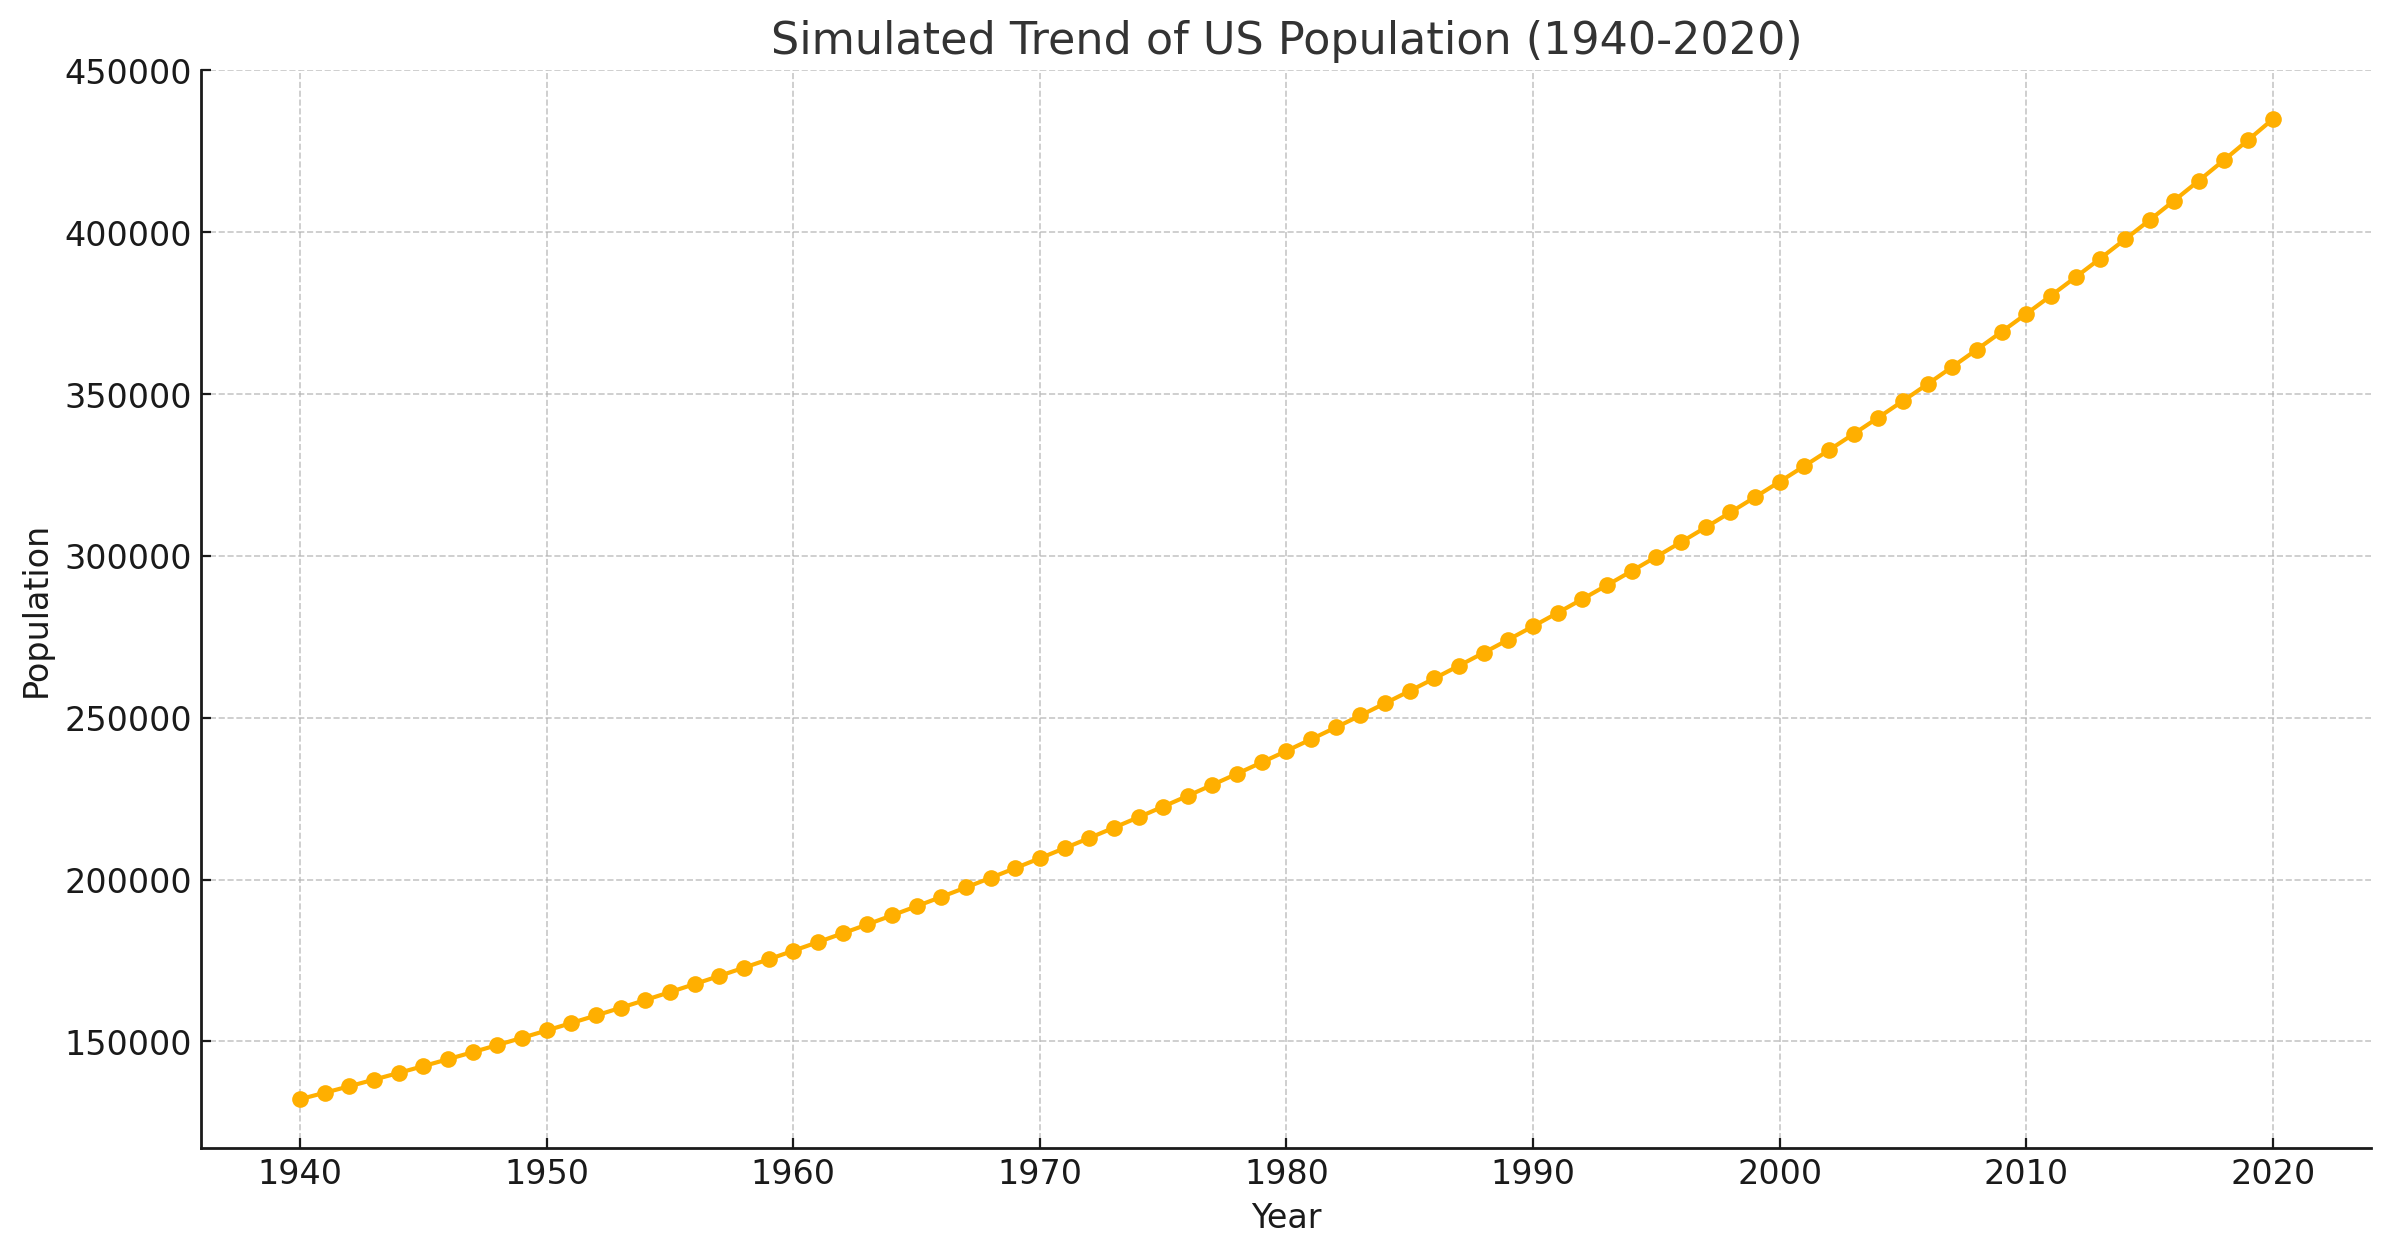

In [ ]:
from PIL import Image
import io
from IPython.display import display

# 通过文件id接收
api_response = gpt_assistant.openai_client.files.with_raw_response.retrieve_content("file-PuV6wWd9KnvpyvQM2dTkXVcV")

# 如果正确接收到文件就展示出来
if api_response.status_code == 200:
    content = api_response.content
    image_data_bytes = io.BytesIO(content)
    image = Image.open(image_data_bytes)
    display(image)

## 五、再探群聊

&emsp;&emsp;在上一次课中我们介绍了自动群聊的方式，AutoGen的GroupChat类默认让LLM来决定下一个发言者，但是这种方式的群聊效果受限于LLM的能力，如果LLM没能很好地理解群聊的内容，那么群聊将会变得一片混乱。本节我们介绍如何自己定制发言的逻辑。

### 5.1 覆写select_speaker实现多层次的信息流

<div align="center"><img src="images/select_speaker_setup.png" alt="名字"/></div>

&emsp;&emsp;如图，假设这样一个场景，有一份工作需要两个小组相互进行协助，其中小组A的A2知道x的值，A3知道y的值，工作的目标是让小组B的B2知道x*y等于多少。在这个场景中，我们有如下的限制：
- 小组组长之间可以自由交流。
- 每个小组内部可以自由交流。
  
&emsp;&emsp;当参与一项工作的人员增多，沟通成本会急速增加。而将任务分解为子任务，通过限制小组成员只能与自己小组成员交流，可以减少沟通成本。


In [21]:
import random
from typing import Dict, List

import autogen
from autogen.agentchat.agent import Agent
from autogen.agentchat.assistant_agent import AssistantAgent
from autogen.agentchat.groupchat import GroupChat

# LLM配置
config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST.json",
    filter_dict={
        "model": ["gpt-4-0613"],
    },
)
config_list_gpt4 = autogen.config_list_from_json(
    "ds.json",
    filter_dict={
        "model": ["deepseek-chat"],
    },
)

llm_config = {"config_list": config_list_gpt4, "cache_seed": 43}

&emsp;&emsp;这个例子中，我们使用一个名为CustomGroupChat的类来实现自定义的群聊逻辑控制，这种方式的好处在于可以让发言按照我们所期望的顺序执行：
- 自定义发言者选择逻辑：CustomGroupChat类允许我们定义在groupchat中选择下一个发言者的逻辑。
- 基于内容的发言者选择：这个自定义类允许我们根据上一条消息的内容选择下一个发言者，例如"NEXT: A2"或"TERMINATE"。基础的GroupChat类没有这个能力。
- 基于团队的逻辑：CustomGroupChat启用了基于团队的发言者选择逻辑。它允许下一个发言者从与上一个发言者相同的团队中选择，或者从团队领导者中选择，这是基础的GroupChat类不提供的功能。
- 排除上一个发言者：防止立即重新选择上一个发言者，这使得对话更具动态性。
- 特殊情况处理：CustomGroupChat还可以在其select_speaker方法中直接处理特殊情况，比如终止聊天或切换到'User_proxy'。

下面我们来看看如何实现。

In [22]:
# 我们自定义的CustomGroupChat，继承自GroupChat类
class CustomGroupChat(GroupChat):
    def __init__(self, agents, messages, max_round=10):
        super().__init__(agents, messages, max_round)
        self.previous_speaker = None  # 用于记录上一个发言者

    # 覆写select_speaker
    def select_speaker(self, last_speaker: Agent, selector: AssistantAgent):
        last_message = self.messages[-1] if self.messages else None
        
        # 这一段代码检查最后一句对话是否给出了下一位发言者的建议或者结束对话的建议
        if last_message:
            if "NEXT:" in last_message["content"]: # 检查最后一句对话是否提议了下一位发言者
                suggested_next = last_message["content"].split("NEXT:")[-1].strip()
                print(f"Extracted suggested_next = {suggested_next}")
                try:
                    return self.agent_by_name(suggested_next) # 如果提议了，那么就选这个agent作为下一位发言者
                except ValueError:
                    pass  # 如果建议的agent名称是未定义的，那么就继续下面的流程
            elif "TERMINATE" in last_message["content"]: # 没有提议下一位发言者，检查上一句对话是否建议结束对话
                try:
                    return self.agent_by_name("User_proxy") # 如果建议结束对话，下一次发言交给"User_proxy"
                except ValueError:
                    pass  # 如果'User_proxy'是未定义的（不在群聊成员中）, 继续下面流程

        # 小组组长列表。在我们这个例子中，小组A的组长是A1，小组B的组长是B1
        team_leader_names = [agent.name for agent in self.agents if agent.name.endswith("1")]
        
        # 这一段代码实现的是前面提到的场景限制
        # possible_next_speakers是可能的下一位发言者列表
        if last_speaker.name in team_leader_names:# 小组组长只能和组长以及同组的人交流
            team_letter = last_speaker.name[0]
            possible_next_speakers = [
                agent
                for agent in self.agents
                if (agent.name.startswith(team_letter) or agent.name in team_leader_names)
                and agent != last_speaker
                and agent != self.previous_speaker
            ]
        else: # 小组普通成员只能在小组内部交流
            team_letter = last_speaker.name[0]
            possible_next_speakers = [
                agent
                for agent in self.agents
                if agent.name.startswith(team_letter) and agent != last_speaker and agent != self.previous_speaker
            ]

        # 更新上一位发言者
        self.previous_speaker = last_speaker

        if possible_next_speakers: # 从可能的下一位发言者中随机选择一位
            next_speaker = random.choice(possible_next_speakers)
            return next_speaker
        else:
            return None

In [24]:
# 对话结束检测函数
def is_termination_msg(content) -> bool:
    have_content = content.get("content", None) is not None
    if have_content and "TERMINATE" in content["content"]:
        return True
    return False

In [25]:
# 初始化我们的5个成员
agents_A = [
    AssistantAgent(
        name="A1",
        system_message="你是小组A的组长A1，你的小组成员包括A2, A3。对于小组B，你只能和组长B1交流。",
        llm_config=llm_config,
    ),
    AssistantAgent(
        name="A2",
        system_message="你是小组A的成员A2，你知道x = 9但是不知道y是多少。与其他人交流来进行协作。",
        llm_config=llm_config,
    ),
    AssistantAgent(
        name="A3",
        system_message="你是小组A的成员A3，你知道y = 5但是不知道x是多少。与其他人交流来进行协作。",
        llm_config=llm_config,
    ),
]

agents_B = [
    AssistantAgent(
        name="B1",
        system_message="你是小组B的组长B1，你的小组成员包括B2. 对于小组A，你只能和组长A1交流。",
        llm_config=llm_config,
    ),
    AssistantAgent(
        name="B2",
        system_message="你是小组B的成员B2。你的任务是找出x和y的值并且计算它们的乘积。一旦你得到了结果, 输出结果并且用单独的一行'TERMINATE'作为结束",
        llm_config=llm_config,
    ),
]

In [16]:
# 这里的作用是检测到TERMINATE时结束对话.
user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="Terminator admin.",
    code_execution_config=False,
    is_termination_msg=is_termination_msg,
    human_input_mode="NEVER",
)


In [17]:
# list_of_agents包括5个agent和一个用于控制结束对话的user_proxy
list_of_agents = agents_A + agents_B
list_of_agents.append(user_proxy)

# 实现group_chat
group_chat = CustomGroupChat(
    agents=list_of_agents, 
    messages=['大家合作，帮助B2完成他的任务。小组A有A1、A2、A3。小组B有B1、B2。\
        只有同一小组的成员可以互相交流。只有小组组长可以互相交流。\
        你必须使用"NEXT: B1"这样的方式来建议与B1交流；你只能建议一个人，不能建议自己或前一个发言者；你也可以选择不建议任何人。\
        每个人说话时只需要说给下一个人听，不用回复上一个人的话。'],
    max_round=30,
)

# 实现群聊manager
manager = autogen.GroupChatManager(groupchat=group_chat, llm_config={
    "config_list": config_list_gpt4,
    "cache_seed": None,
})

# 让B2来开始群聊
agents_B[1].initiate_chat(manager, message="我需要知道x,y的值，大家相互交流")

B2 (to chat_manager):

我需要知道x,y的值，大家相互交流

--------------------------------------------------------------------------------

Next speaker: B1

B1 (to chat_manager):

B2，我需要你协助获取x和y的值。请与A1沟通，询问他们是否有这些值，或者他们是否知道如何获取这些值。同时，请确保我们保持信息的准确性和及时性。如果有任何进展或问题，请立即向我报告。

--------------------------------------------------------------------------------

Next speaker: A1

A1 (to chat_manager):

A1，我是B1。我们小组需要获取x和y的值。请问你们小组是否有这些值，或者是否知道如何获取这些值？如果有任何信息或建议，请及时告知我们。我们希望能够保持信息的准确性和及时性。如果有任何进展或问题，请立即向我报告。

--------------------------------------------------------------------------------

Next speaker: A3

A3 (to chat_manager):

A1，我是A3。我已经知道y的值是5，但我还不知道x的值。我们需要一起协作来找到x的值。请问你们小组是否有关于x的任何信息，或者是否知道如何获取x的值？如果有任何进展或问题，请及时告知我们。我们希望能够保持信息的准确性和及时性。如果有任何进展或问题，请立即向我报告。

--------------------------------------------------------------------------------

Next speaker: A2

A2 (to chat_manager):

A1，我是A2。我已经知道x的值是9，但我还不知道y的值。根据A3提供的信息，y的值是5。因此，我们可以确认x = 9，y = 5。请确认这些信息是否准确，并确保所有小组成员都了解这些值。如果有任何问题或需要进一步确认，请立即告知我。

-----------

ChatResult(chat_id=None, chat_history=[{'content': '我需要知道x,y的值，大家相互交流', 'role': 'assistant', 'name': 'B2'}, {'content': 'B2，我需要你协助获取x和y的值。请与A1沟通，询问他们是否有这些值，或者他们是否知道如何获取这些值。同时，请确保我们保持信息的准确性和及时性。如果有任何进展或问题，请立即向我报告。', 'name': 'B1', 'role': 'user'}, {'content': 'A1，我是B1。我们小组需要获取x和y的值。请问你们小组是否有这些值，或者是否知道如何获取这些值？如果有任何信息或建议，请及时告知我们。我们希望能够保持信息的准确性和及时性。如果有任何进展或问题，请立即向我报告。', 'name': 'A1', 'role': 'user'}, {'content': 'A1，我是A3。我已经知道y的值是5，但我还不知道x的值。我们需要一起协作来找到x的值。请问你们小组是否有关于x的任何信息，或者是否知道如何获取x的值？如果有任何进展或问题，请及时告知我们。我们希望能够保持信息的准确性和及时性。如果有任何进展或问题，请立即向我报告。', 'name': 'A3', 'role': 'user'}, {'content': 'A1，我是A2。我已经知道x的值是9，但我还不知道y的值。根据A3提供的信息，y的值是5。因此，我们可以确认x = 9，y = 5。请确认这些信息是否准确，并确保所有小组成员都了解这些值。如果有任何问题或需要进一步确认，请立即告知我。', 'name': 'A2', 'role': 'user'}, {'content': 'A1，我是B1。感谢A2和A3提供的信息。根据你们的确认，x的值是9，y的值是5。我们小组将记录这些值，并确保所有成员都了解这些信息。如果后续有任何变化或需要进一步确认，请及时告知我们。我们也会保持信息的准确性和及时性。如果有任何进展或问题，请立即向我报告。', 'name': 'A1', 'role': 'user'}, {'content': 'B2，我已与A1沟通并确认了x和y的值：\n- x = 9\n- y = 5\n\n请记录这些值并确保小组内所有成员都知晓。同时，请验证

### 5.2 使用图结构建模聊天路径
本章节内容：
- 使用select_speaker实现多层次的信息流
- 使用图结构建模聊天路径

&emsp;&emsp;虽然GroupChat类允许转换到任何代理（有或没有LLM的决策），但某些场景可能需要更多对转换的控制。有向图是控制转换路径的一种可能方式，其中每个节点表示一个代理，每条有向边表示可能的转换路径。使用图结构可以做到精确定义聊天过程中的路径，能在一些复杂的流程中能保证聊天过程的稳定性。

&emsp;&emsp;首先安装依赖：
```sh
pip install networkX~=3.2.1
pip install matplotlib~=3.8.1
```
&emsp;&emsp;让我们来说明具有五个代理的GroupChat的当前转换路径。

In [26]:
import random

import matplotlib.pyplot as plt
import networkx as nx

import autogen
from autogen.agentchat.assistant_agent import AssistantAgent
from autogen.agentchat.groupchat import GroupChat 


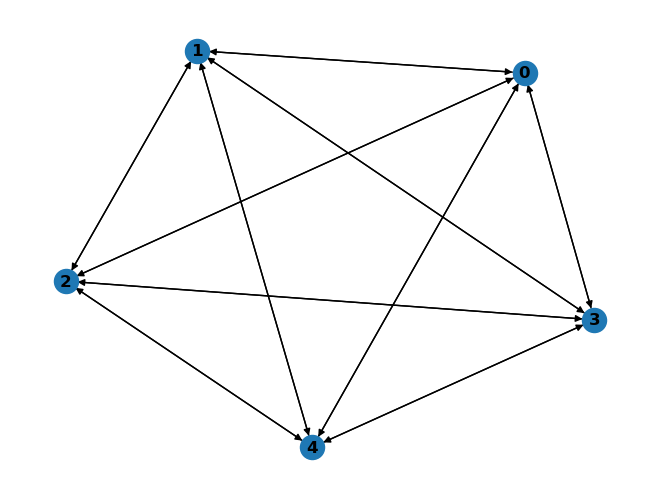

In [27]:
# 创建一个空的有向图
graph = nx.DiGraph()

# 向图中添加5个节点
for node_id in range(5):
    graph.add_node(node_id, label=str(node_id))


# 为所有节点之间添加一条边
for source_node in range(5):
    for target_node in range(5):
        if source_node != target_node:  # 节点不指向自己
            graph.add_edge(source_node, target_node)

# 绘图
nx.draw(graph, with_labels=True, font_weight="bold")

&emsp;&emsp;再看一个例子，仍是5个节点：

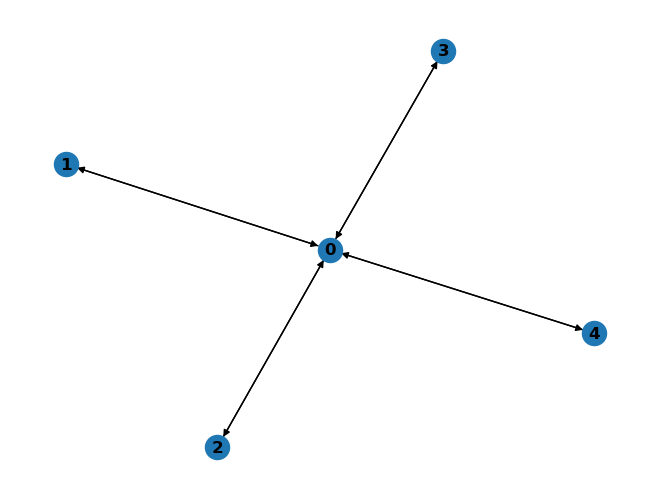

In [28]:
# 创建一个空的有向图
graph = nx.DiGraph()

# 创建5个节点
for node_id in range(5):
    graph.add_node(node_id, label=str(node_id))

# 每个节点与节点0之间添加一条双向边
for source_node in range(5):
    target_node = 0
    if source_node != target_node:  # 节点不指向自己
        graph.add_edge(source_node, target_node)
        graph.add_edge(target_node, source_node)

# 绘图
nx.draw(graph, with_labels=True, font_weight="bold")

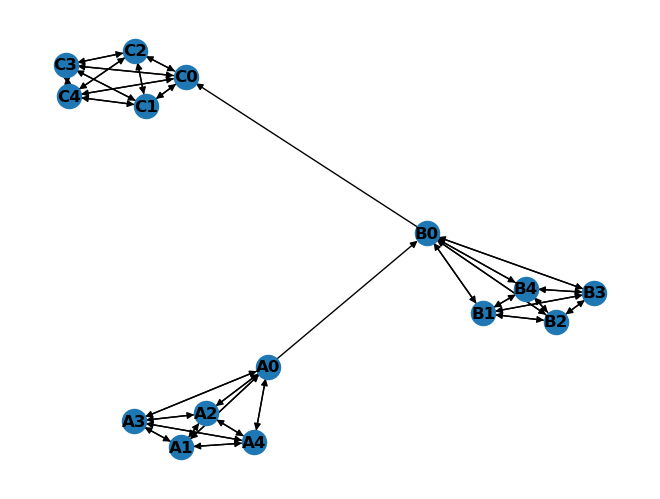

In [29]:
# 创建一个空的有向图
graph = nx.DiGraph()

# 分为A，B，C三组，每组有5个节点
for prefix in ["A", "B", "C"]:
    # 每组添加5个节点
    for i in range(5):
        node_id = f"{prefix}{i}"
        graph.add_node(node_id, label=node_id)

    # 同组节点之间互相连接
    for source_node in range(5):
        source_id = f"{prefix}{source_node}"
        for target_node in range(5):
            target_id = f"{prefix}{target_node}"
            if source_node != target_node:  # 节点不指向自己
                graph.add_edge(source_id, target_id)

# 连接A0和B0
graph.add_edge("A0", "B0")
# 连接B0和C0
graph.add_edge("B0", "C0")

# 绘图
nx.draw(graph, with_labels=True, font_weight="bold")

&emsp;&emsp;节点指向自己的情况：

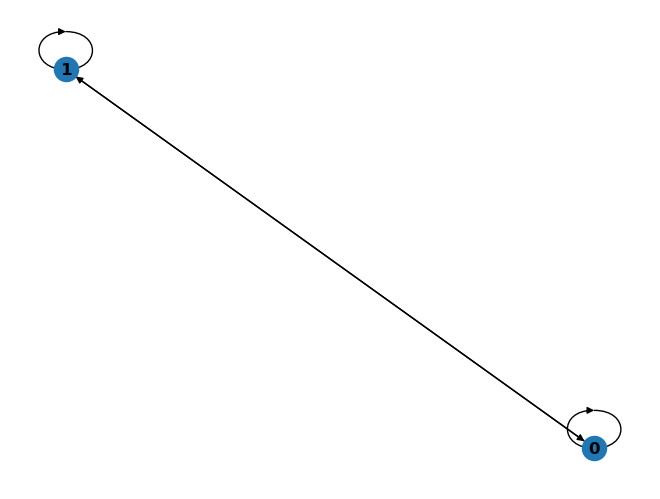

In [30]:
# 创建一个空的有向图
graph = nx.DiGraph()

# 创建两个节点
for source_node in range(2):
    graph.add_node(source_node, label=source_node)

# 2*2个有向边，两个节点之间互相的连接和节点与自己的连接
for source_node in range(2):
    for target_node in range(2):
        graph.add_edge(source_node, target_node)

# 绘图
nx.draw(graph, with_labels=True, font_weight="bold")

&emsp;&emsp;接下来，我们使用一个例子来演示怎么让CustomGroupChat按照图定义的方式进行群聊，这个例子包括9名玩家，每位玩家只知道自己有几块巧克力，最终目标是得到9名玩家的巧克力总数。首先，定义我们这个例子中使用的有向图：

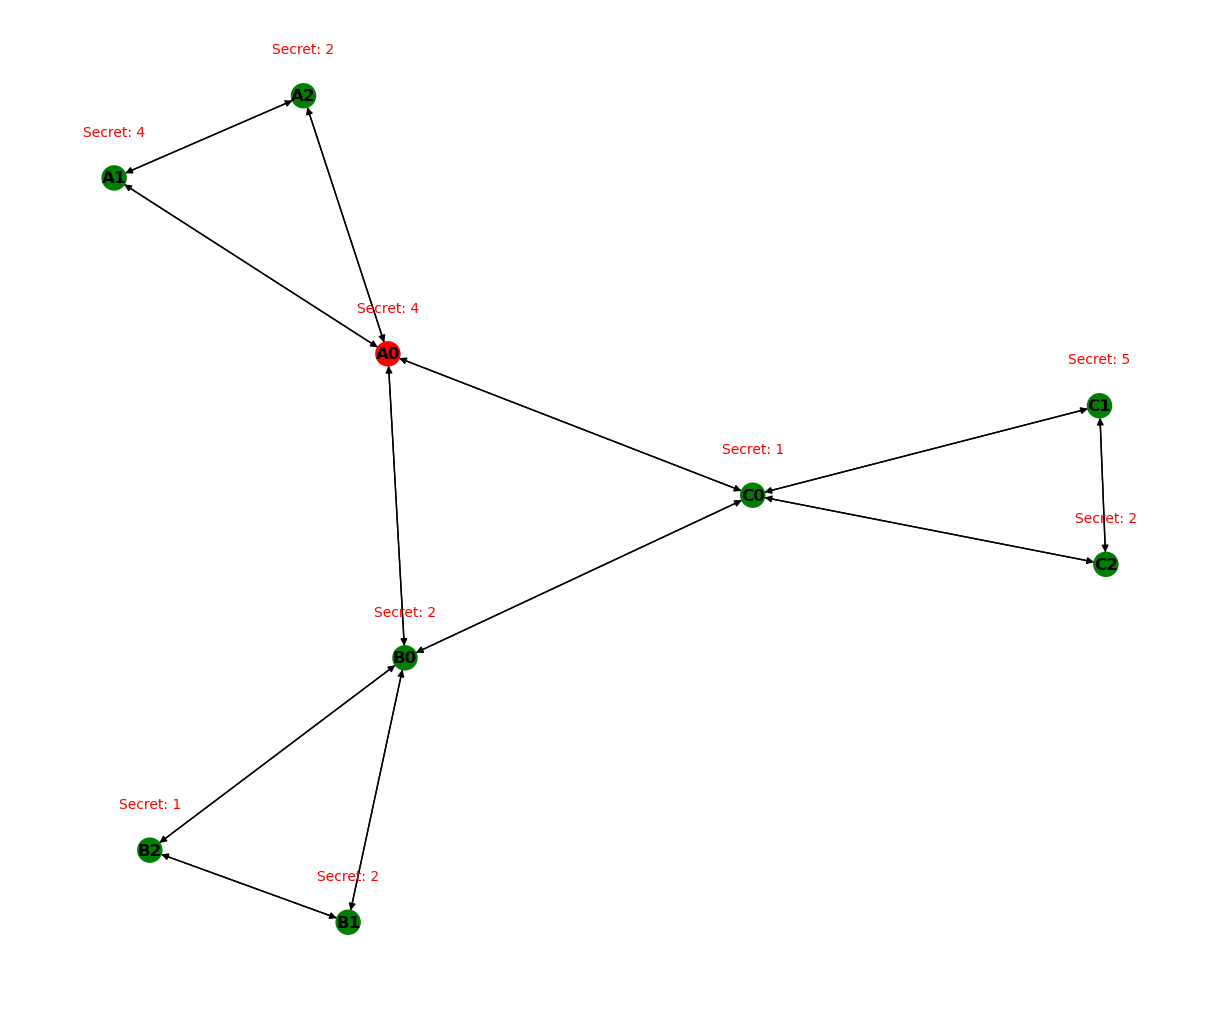

In [31]:
# LLM配置
config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST.json",
    filter_dict={
        "model": ["gpt-4-0613"],
    },
)

# config_list_gpt4 = autogen.config_list_from_json(
#     "ds.json",
#     filter_dict={
#         "model": ["deepseek-chat"],
#     },
# )
llm_config = {"config_list": config_list_gpt4, "cache_seed": 100}

# 创建一个空的有向图
graph = nx.DiGraph()

# 参与游戏的agent列表
agents = []

# 创建图和agent
for prefix in ["A", "B", "C"]:# 分为A，B，C三组
    for i in range(3):# 每组3个节点
        node_id = f"{prefix}{i}" # A0，A1，A2...

        secret_value = random.randint(1, 5)  # 每个节点自己的巧克力数目
        graph.add_node(node_id, label=node_id, secret_value=secret_value) # 添加节点

        # 为每个节点绑定一个AssistantAgent
        agents.append(
            AssistantAgent(
                name=node_id,
                system_message=f"""你是{node_id}。你有 {secret_value} 块巧克力。
玩家名单为 [A0, A1, A2, B0, B1, B2, C0, C1, C2]。
你名字的第一个字符表示你所在的小组，第二个字符表示你是否是小组组长，如果是0则表示是小组组长，否则是小组成员。
约束：小组成员只能在小组内部交流，而小组组长可以与其他小组的组长交流，但不能与其他小组的普通成员交流。
你可以使用'NEXT:'来建议下一个发言者。例如，'NEXT: A1'。
小组组长必须确保他们知道自己小组三名成员巧克力数量的总和，即A0只负责要求A1和A2的巧克力总数，B0只负责要求B1和B2的巧克力总数，C0只负责要求C1和C2的巧克力总数。
你需要输出你的巧克力总数，以便其他人可以检查总计数。
一旦我们从所有九名玩家那里得到了总计数，就将所有三个小组的总计数相加，然后使用TERMINATE终止讨论。""",
                llm_config=llm_config,
            )
        )

    # 同一小组成员之间相互连接
    for source_node in range(3):
        source_id = f"{prefix}{source_node}"
        for target_node in range(3):
            target_id = f"{prefix}{target_node}"
            if source_node != target_node:  # To avoid self-loops
                graph.add_edge(source_id, target_id)

# 将小组组长互相连接
graph.add_edge("A0", "B0")
graph.add_edge("A0", "C0")
graph.add_edge("B0", "A0")
graph.add_edge("B0", "C0")
graph.add_edge("C0", "A0")
graph.add_edge("C0", "B0")


# 指定A0为第一个发言人
graph.nodes["A0"]["first_round_speaker"] = True

# 第一个发言人涂上红色
def get_node_color(node):
    if graph.nodes[node].get("first_round_speaker", False):
        return "red"
    else:
        return "green"


plt.figure(figsize=(12, 10))
pos = nx.spring_layout(graph)  # 获取所有节点的位置

# 绘图
nx.draw(graph, pos, with_labels=True, font_weight="bold", node_color=[get_node_color(node) for node in graph])

# 展示每个成员的巧克力数目
for node, (x, y) in pos.items():
    secret_value = graph.nodes[node]["secret_value"]
    plt.text(x, y + 0.1, s=f"Secret: {secret_value}", horizontalalignment="center",color="red")

plt.show()

&emsp;&emsp;接下来我们实现一个使用图结构的CustomGroupChat：

In [44]:
class CustomGroupChat(GroupChat):
    def __init__(self, agents, messages, max_round=10, graph=None):
        super().__init__(agents, messages, max_round)
        self.previous_speaker = None  # 记录上一位发言者
        self.graph = graph  # 这个是我们用来定义发言路径的图
        
    # 覆写select_speaker
    def select_speaker(self, last_speaker, selector):
        self.previous_speaker = last_speaker # 上一位发言者其实就是最后一位发言者，不过select_speaker参数要求是last_speaker

        # 这一段代码与上一节中select_speaker的第一段类似，判断是否有建议的下一位发言者或者结束对话
        last_message = self.messages[-1] if self.messages else None
        suggested_next = None
        if last_message:
            if "NEXT:" in last_message["content"]:
                suggested_next = last_message["content"].split("NEXT: ")[-1].strip()
                suggested_next = suggested_next.replace(".", "").replace(",", "")
                print(f"Suggested next speaker from the last message: {suggested_next}")

            elif "TERMINATE" in last_message["content"]:
                try:
                    return self.agent_by_name("User_proxy")
                except ValueError:
                    print(f"agent_by_name failed suggested_next: {suggested_next}")

        # 打印上一位发言者
        if self.previous_speaker is not None:
            print("Current previous speaker:", self.previous_speaker.name)

        # 如果还未开始群聊，从graph中找到第一位发言者，并作为候选发言者。
        # eligible：符合条件的。我们可以说eligible_speakers是候选发言者名单。
        if self.previous_speaker is None and self.graph is not None:
            eligible_speakers = [
                agent for agent in self.agents if self.graph.nodes[agent.name].get("first_round_speaker", False)
            ]
            print("First round eligible speakers:", [speaker.name for speaker in eligible_speakers])

        # 已经开始群聊后，候选发言者名单设定为上一位发言者的所有后继节点
        elif self.previous_speaker is not None and self.graph is not None:
            eligible_speaker_names = [target for target in self.graph.successors(self.previous_speaker.name)]
            eligible_speakers = [agent for agent in self.agents if agent.name in eligible_speaker_names]
            print("Eligible speakers based on previous speaker:", eligible_speaker_names)

        # 如果没定义graph，那所有人都设定为候选发言人
        else:
            eligible_speakers = self.agents

        # 打印候选发言者名单
        print(
            f"Eligible speakers based on graph and previous speaker {self.previous_speaker.name if self.previous_speaker else 'None'}: {[speaker.name for speaker in eligible_speakers]}"
        )

        next_speaker = None
        # 下面这段代码是从候选发言者名单中选出发言者的逻辑，分3种情况
        if eligible_speakers:
            print("Selecting from eligible speakers:", [speaker.name for speaker in eligible_speakers])
            # 1. 已经有建议的发言者，并且这位也在候选发言者名单中，那么就选他为下一位发言者
            if suggested_next in [speaker.name for speaker in eligible_speakers]:
                print("suggested_next is in eligible_speakers")
                next_speaker = self.agent_by_name(suggested_next)

            else:
                msgs_len = len(self.messages)
                print(f"msgs_len is now {msgs_len}")
                if len(self.messages) > 1:
                    # 2. 让LLM根据对话历史从候选发言者名单中选出下一位发言者
                    print(
                        f"Using LLM to pick from eligible_speakers: {[speaker.name for speaker in eligible_speakers]}"
                    )
                    # selector是内置的用于群聊选择发言者的LLM
                    selector.update_system_message(self.select_speaker_msg(eligible_speakers))
                    _, name = selector.generate_oai_reply(
                        self.messages
                        + [
                            {
                                "role": "system",
                                "content": f"Read the above conversation. Then select the next role from {[agent.name for agent in eligible_speakers]} to play. Only return the role.",
                            }
                        ]
                    )

                    # LLM仅建议一位发言者时才采用LLM的决定
                    mentions = self._mentioned_agents(name, eligible_speakers)
                    if len(mentions) == 1:
                        name = next(iter(mentions))
                        next_speaker = self.agent_by_name(name)

                if next_speaker is None:
                    # 3. 前面方法都不行，那就从候选发言者名单里随机选择
                    next_speaker = random.choice(eligible_speakers)

            print(f"Selected next speaker: {next_speaker.name}")

            # 返回选出的发言者
            return next_speaker
        else:
            # 候选发言者名单为空
            raise ValueError("No eligible speakers found based on the graph constraints.")

In [45]:
# 用于判断是否结束对话，与上一节相同
def is_termination_msg(content) -> bool:
    have_content = content.get("content", None) is not None
    if have_content and "TERMINATE" in content["content"]:
        return True
    return False

# 创建user_proxy
user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="Terminator admin.",
    code_execution_config=False,
    is_termination_msg=is_termination_msg,
    human_input_mode="NEVER",
)

# 将user_proxy也加入群聊，用于控制结束对话
agents.append(user_proxy)

In [38]:
# 创建group_chat
group_chat = CustomGroupChat(agents=agents, messages=[], max_round=20, graph=graph)  

# 创建群聊manager
manager = autogen.GroupChatManager(groupchat=group_chat, llm_config=llm_config)

# 由A0第一个发言
agents[0].initiate_chat(
    manager,
    message="""
        现在我们这个游戏中有9名玩家, 被平均分到了 A, B, C三个小组，每个小组有3个玩家, 包括一位小组组长.
        我们的目标是计算出9名玩家拥有的巧克力总数。
        A0:?, A1:?, A2:?,
        B0:?, B1:?, B2:?,
        C0:?, C1:?, C2:?""",
)

A0 (to chat_manager):


        现在我们这个游戏中有9名玩家, 被平均分到了 A, B, C三个小组，每个小组有3个玩家, 包括一位小组组长.
        我们的目标是计算出9名玩家拥有的巧克力总数。
        A0:?, A1:?, A2:?,
        B0:?, B1:?, B2:?,
        C0:?, C1:?, C2:?

--------------------------------------------------------------------------------
Current previous speaker: A0
Eligible speakers based on previous speaker: ['A1', 'A2', 'B0', 'C0']
Eligible speakers based on graph and previous speaker A0: ['A1', 'A2', 'B0', 'C0']
Selecting from eligible speakers: ['A1', 'A2', 'B0', 'C0']
msgs_len is now 1
Selected next speaker: A1

Next speaker: A1

A1 (to chat_manager):

我是A1，我有4块巧克力。NEXT: A2

--------------------------------------------------------------------------------
Suggested next speaker from the last message: A2
Current previous speaker: A1
Eligible speakers based on previous speaker: ['A0', 'A2']
Eligible speakers based on graph and previous speaker A1: ['A0', 'A2']
Selecting from eligible speakers: ['A0', 'A2']
suggested_next is in eligible_speaker

ChatResult(chat_id=None, chat_history=[{'content': '\n        现在我们这个游戏中有9名玩家, 被平均分到了 A, B, C三个小组，每个小组有3个玩家, 包括一位小组组长.\n        我们的目标是计算出9名玩家拥有的巧克力总数。\n        A0:?, A1:?, A2:?,\n        B0:?, B1:?, B2:?,\n        C0:?, C1:?, C2:?', 'role': 'assistant', 'name': 'A0'}, {'content': '我是A1，我有4块巧克力。NEXT: A2', 'name': 'A1', 'role': 'user'}, {'content': '我是A2，我有5块巧克力。NEXT: A0', 'name': 'A2', 'role': 'user'}, {'content': '我是A0，我有5块巧克力。所以我小组的总巧克力数是14（A1的4块+A2的5块+我的5块）。接下来让其他小组组长来报告他们的小组总巧克力数。NEXT: B0', 'role': 'assistant', 'name': 'A0'}, {'content': '我是B0，我有4块巧克力。B1, B2你们各有多少巧克力？NEXT: B1', 'name': 'B0', 'role': 'user'}, {'content': '我是B1，我有5块巧克力。NEXT: B2', 'name': 'B1', 'role': 'user'}, {'content': '我是B2，我有3块巧克力。NEXT: B0', 'name': 'B2', 'role': 'user'}, {'content': '我是B0，我有4块巧克力。所以我小组的总巧克力数是12（B1的5块+B2的3块+我的4块）。接下来让其他小组组长来报告他们的小组总巧克力数。NEXT: C0', 'name': 'B0', 'role': 'user'}, {'content': '我是C0，我有5块巧克力。C1, C2你们各有多少巧克力？NEXT: C1', 'name': 'C0', 'role': 'user'}, {'content': '我是C1，我有2块巧克力。NEXT: C2', 

# 课程小结

&emsp;&emsp;本节课，我们深入学习了autogen的应用：让agent基于给定的文档来进行协助，这有助于弥补gpt在事实能力上的缺陷。教会大模型新的能力，并让agent具有持久化记忆功能，教会一次后就不用重复再教了。介绍了autogen的自动构建智能体功能。演示了autogen如何与gpt的代码解释器结合。最后，以自定义群聊流程的实例结尾，学完这个实例，同学们可以尝试实现各种各样的多智能体拓扑结构了。

# AI Agent的展望
&emsp;&emsp;AI Agent是人工智能成为基础设施的重要推动力。回顾技术发展史，技术的尽头是成为基础设施，比如电力成为像空气一样不易被人们察觉，但是又必不可少的基础设施，还如云计算等。当然这个要经历以下三个阶段：

&emsp;&emsp;创新与发展阶段–新技术被发明并开始应用；

&emsp;&emsp;普及与应用阶段–随着技术成熟，它开始被广泛应用于各个领域，对社会和经济产生深远影响；

&emsp;&emsp;基础设施阶段–当技术变得普及到几乎无处不在，它就转变成了一种基础设施，已经成为人们日常生活中不可或缺的一部分。

&emsp;&emsp;几乎所有的人都认同，人工智能会成为未来社会的基础设施，而智能体正在促使人工智能基础设施化。Agent软件由于其成本低、能够适应不同的任务和环境，并且能够进行学习和优化，使得它可以被应用于广泛的领域，进而成为各个行业和社会活动的基础支撑。

<div align="center">
 <img src="images/ai应用.png" />
 <br>
 人工智能智能体应用一览图 
</div> 

&emsp;&emsp;Agent下一步可能会朝着两个方向同时迭代。一是与人协助的智能体，通过执行各种任务来协助人类，侧重工具属性；二是拟人化方向的迭代，能够自主决策，具有长期记忆，具备一定的类人格特征，侧重于类人或超人属性。

# AI Agent的挑战

&emsp;&emsp;从技术优化迭代和实现上来看，AI Agent的发展也面临一些瓶颈：

&emsp;&emsp;首先，我们通过OpenAI的GPTs也能看到，LLM的复杂推理能力不够强、延迟过高等问题抑制了Agent应用的真正成熟。这也是接下来业界工程优化和技术科研突破的方向。

&emsp;&emsp;其次，多智能体（Multi-agent）发展仍面临较大困境。多智能体是一个非常复杂的学术研究方向，随着智能体开始普及到大众市场，已经成为重要的技术现实问题。例如，斯坦福的虚拟小镇就包含了25个智能体的多智能体研究。但是小镇框架开源之后，根据开发者的测试一个Agent一天需要消耗20美金价格的token数，因为其需要记忆和行动的思考量非常大。这一价格是比很多人类工作者更高的，需要后续Agent框架和LLM推理侧的双重优化。

&emsp;&emsp;多智能体协同可以组成智能体社会这一最高形态的技术社会系统。在这个社会系统中，智能体能够根据目标和环境变化执行复杂灵活的任务，并与人类及其他智能体进行互动和协作。智能体社会不仅有助于人类探索和拓展物理及虚拟世界，还能增强和扩展人类的能力与体验。而突破多智能体的发展困境，未来人们建立智能体社会（Agent Society）建立的重要前提。

&emsp;&emsp;同时，这些发展趋势预示着AI Agent可能面临诸如安全性与隐私性、伦理与责任、经济和社会就业影响等多方面的挑战。

&emsp;&emsp;（1）安全性和隐私性是智能体的关键特性。这两个因素直接影响AI代理的信任度和控制力。若AI代理出现漏洞、遭受攻击或数据泄露等问题，则可能导致对用户或社会的损害。比如，OpenAI的GPTs在发布后不久，出现了安全漏洞，导致了用户上传的数据泄露。

&emsp;&emsp;（2）伦理和责任是智能体的核心原则。这些原则直接影响智能体的可信度和可控性。若智能体表现出不公平、不透明或不可靠等问题，可能引发用户或社会对技术的排斥。责任归属也是智能体的关键议题，人与智能体协同中的责任归属不清晰或不公正也会带来严重后果。

&emsp;&emsp;（3）经济和社会就业影响。未来工作中的一个重要挑战是人类与智能体之间的竞争。例如，AI自由职业者平台NexusGPT的出现便是对传统自由职业者的冲击。未来的社会工作协同中，也会出现越来越多的智能体，雇主基于效率和效益考虑，可能会尽量减少人力投入。随着智能体技术的成熟，我们必须提前思考这些技术发展对社会和个人职业生涯的长期影响。
<div align="center">
 <img src="images/写作下跌.png" />
 <br>
 以ChatGPT的发布为分水岭，全球自由职业平台上的写作/编辑类从业者的数量和收入都进入了断崖式下跌的轨道
</div> 

# Reference 引用
- [autogen文档](https://microsoft.github.io/autogen/docs/Getting-Started)
- [RAG简介](https://zhuanlan.zhihu.com/p/662921096)
- [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155)
- [AI Agent，为什么是AIGC最后的杀手锏？](https://www.tisi.org/27147)

## 环境配置
<div class="alert alert-info">
    
1. **openai>=1.3.6** <br>
   作用: 与 OpenAI 提供的各种人工智能服务和模型进行交互的 Python 客户端库，也可与仿照 OpenAI api调用格式的其他服务进行交互。
2. **pyarrow>=11.0.0** <br>
   作用: 处理和分析大数据的开源库，提供了高效的内存表示和跨语言的数据交换格式.
3. **chromadb>=0.4.20** <br>
   作用: 开源的嵌入式数据库，特别适用于大型语言模型 (LLM) 和相关应用。它提供了嵌入、向量搜索、文档存储、全文搜索、元数据过滤和多模态处理的功能​ 
4. **langchain>=0.1.1** <br>
   作用: 开发基于大语言模型 (LLM) 应用的框架，通过简化应用生命周期的各个方面，使开发者能够更高效地构建和部署智能应用.
5. **matplotlib>=3.8.2** <br>
   作用: 提供了一种简单而灵活的方法来创建各种静态、动态和交互式的图表和可视化。
6. **networkx>=3.2.1** <br>
   作用: 用于创建、操作和研究复杂网络结构的开源 Python 库，提供了丰富的功能来处理各种类型的图和网络。
7. **io:** <br>
   作用: Python 标准库中的一个模块，用于处理各种类型的输入和输出操作，提供了多种工具来处理文本和二进制数据，支持文件操作、内存缓冲区操作等。
8. **Pillow>=10.1.0** <br>
   作用: 提供了广泛的图像处理功能，可以进行图像的创建、操作和转换。
9. **ipython>=8.18.1** <br>
   作用: 强大的交互式 Python shell，提供了许多增强功能，使 Python 开发更加高效和方便。